# Instanciating the model


In [1]:
from time import time
import argparse
import os

from torch import device
import torch
from torch import optim
import numpy as np

from data_prep import NLIGenData2, OntoGenData, HuggingYelp2
from disentanglement_transformer_extended.models import DisentanglementTransformerVAE, LaggingDisentanglementTransformerVAE
from disentanglement_transformer_extended.h_params import DefaultTransformerHParams as HParams
from disentanglement_transformer_extended.graphs import *
from components.criteria import *
parser = argparse.ArgumentParser()
from torch.nn import MultiheadAttention
# Training and Optimization
k, kz, klstm = 1, 8, 2
parser.add_argument("--test_name", default='unnamed', type=str)
parser.add_argument("--data", default='nli', choices=["nli", "ontonotes", "yelp"], type=str)
parser.add_argument("--csv_out", default='disentFinal.csv', type=str)
parser.add_argument("--max_len", default=17, type=int)
parser.add_argument("--batch_size", default=128, type=int)
parser.add_argument("--grad_accu", default=1, type=int)
parser.add_argument("--n_epochs", default=20, type=int)
parser.add_argument("--test_freq", default=32, type=int)
parser.add_argument("--complete_test_freq", default=160, type=int)
parser.add_argument("--generation_weight", default=1, type=float)
parser.add_argument("--device", default='cuda:0', choices=["cuda:0", "cuda:1", "cuda:2", "cpu"], type=str)
parser.add_argument("--embedding_dim", default=128, type=int)#################"
parser.add_argument("--pretrained_embeddings", default=False, type=bool)#################"
parser.add_argument("--z_size", default=96*kz, type=int)#################"
parser.add_argument("--z_emb_dim", default=192*k, type=int)#################"
parser.add_argument("--n_latents", default=[16, 16, 16], nargs='+', type=int)#################"
parser.add_argument("--text_rep_l", default=3, type=int)
parser.add_argument("--text_rep_h", default=192*k, type=int)
parser.add_argument("--encoder_h", default=192*k, type=int)#################"
parser.add_argument("--encoder_l", default=2, type=int)#################"
parser.add_argument("--decoder_h", default=192*k, type=int)
parser.add_argument("--decoder_l", default=2, type=int)#################"
parser.add_argument("--highway", default=False, type=bool)
parser.add_argument("--markovian", default=True, type=bool)
parser.add_argument('--minimal_enc', dest='minimal_enc', action='store_true')
parser.add_argument('--no-minimal_enc', dest='minimal_enc', action='store_false')
parser.set_defaults(minimal_enc=False)
parser.add_argument("--losses", default='VAE', choices=["VAE", "IWAE" "LagVAE"], type=str)
parser.add_argument("--graph", default='Normal', choices=["Vanilla", "Discrete", "IndepInfer", "Normal", "NormalConGen",
                                                          "NormalSimplePrior", "Normal2",  "NormalLSTM"], type=str)
parser.add_argument("--training_iw_samples", default=1, type=int)
parser.add_argument("--testing_iw_samples", default=5, type=int)
parser.add_argument("--test_prior_samples", default=10, type=int)
parser.add_argument("--anneal_kl0", default=3000, type=int)
parser.add_argument("--anneal_kl1", default=6000, type=int)
parser.add_argument("--grad_clip", default=5., type=float)
parser.add_argument("--kl_th", default=0/(768*k/2), type=float or None)
parser.add_argument("--max_elbo1", default=6.0, type=float)
parser.add_argument("--max_elbo2", default=4.0, type=float)
parser.add_argument("--max_elbo_choice", default=10, type=int)
parser.add_argument("--kl_beta", default=0.4, type=float)
parser.add_argument("--dropout", default=0.3, type=float)
parser.add_argument("--word_dropout", default=0.1, type=float)
parser.add_argument("--l2_reg", default=0, type=float)
parser.add_argument("--lr", default=2e-4, type=float)
parser.add_argument("--lr_reduction", default=4., type=float)
parser.add_argument("--wait_epochs", default=1, type=float)
parser.add_argument("--save_all", default=True, type=bool)

flags, _ = parser.parse_known_args()

# Manual Settings, Deactivate before pushing
if True:
    flags.batch_size = 128
    flags.grad_accu = 1
    flags.max_len = 17
    flags.test_name = "nliLM/SNLIRegular_beta0.4.4"
    # flags.test_name = "nliLM/SNLIWider_beta0.3.3"#"nliLM/SNLIRegular_beta0.4.4"
    flags.data = "nli"
    flags.n_latents = [4]
    flags.graph ="IndepInfer"  # "Vanilla"
    # flags.losses = "LagVAE"
    # flags.kl_beta = 0.5
    # flags.z_size = 16
    # flags.encoder_h = 256
    # flags.decoder_h = 256


# torch.autograd.set_detect_anomaly(True)
GRAPH = {"Vanilla": get_vanilla_graph,
         "Discrete": get_discrete_auto_regressive_graph,
         "IndepInfer": get_structured_auto_regressive_indep_graph,
         "Normal": get_structured_auto_regressive_graph,
         "NormalConGen": get_structured_auto_regressive_graphConGen,
         "Normal2": get_structured_auto_regressive_graph2,
         "NormalLSTM": get_lstm_graph,
         "NormalSimplePrior": get_structured_auto_regressive_simple_prior}[flags.graph]
if flags.graph == "NormalLSTM":
    flags.encoder_h = int(flags.encoder_h/k*klstm)
if flags.graph == "Vanilla":
    flags.n_latents = [flags.z_size]
if flags.losses == "LagVAE":
    flags.anneal_kl0 = 0
    flags.anneal_kl1 = 0
Data = {"nli": NLIGenData2, "ontonotes": OntoGenData, "yelp": HuggingYelp2}[flags.data]
MAX_LEN = flags.max_len
BATCH_SIZE = flags.batch_size
GRAD_ACCU = flags.grad_accu
N_EPOCHS = flags.n_epochs
TEST_FREQ = flags.test_freq
COMPLETE_TEST_FREQ = flags.complete_test_freq
DEVICE = device(flags.device)
# This prevents illegal memory access on multigpu machines (unresolved issue on torch's github)
if flags.device.startswith('cuda'):
    torch.cuda.set_device(int(flags.device[-1]))
LOSSES = {'IWAE': [IWLBo],
          'VAE': [ELBo],
          'LagVAE': [ELBo]}[flags.losses]

ANNEAL_KL = [flags.anneal_kl0*flags.grad_accu, flags.anneal_kl1*flags.grad_accu]
LOSS_PARAMS = [1]
if flags.grad_accu > 1:
    LOSS_PARAMS = [w/flags.grad_accu for w in LOSS_PARAMS]


data = Data(MAX_LEN, BATCH_SIZE, N_EPOCHS, DEVICE, pretrained=flags.pretrained_embeddings)
h_params = HParams(len(data.vocab.itos), len(data.tags.itos) if flags.data == 'yelp' else None, MAX_LEN, BATCH_SIZE, N_EPOCHS,
                   device=DEVICE, vocab_ignore_index=data.vocab.stoi['<pad>'], decoder_h=flags.decoder_h,
                   decoder_l=flags.decoder_l, encoder_h=flags.encoder_h, encoder_l=flags.encoder_l,
                   text_rep_h=flags.text_rep_h, text_rep_l=flags.text_rep_l,
                   test_name=flags.test_name, grad_accumulation_steps=GRAD_ACCU,
                   optimizer_kwargs={'lr': flags.lr, #'weight_decay': flags.l2_reg, 't0':100, 'lambd':0.},
                                     'weight_decay': flags.l2_reg, 'betas': (0.9, 0.99)},
                   is_weighted=[], graph_generator=GRAPH,
                   z_size=flags.z_size, embedding_dim=flags.embedding_dim, anneal_kl=ANNEAL_KL,
                   grad_clip=flags.grad_clip*flags.grad_accu, kl_th=flags.kl_th, highway=flags.highway,
                   losses=LOSSES, dropout=flags.dropout, training_iw_samples=flags.training_iw_samples,
                   testing_iw_samples=flags.testing_iw_samples, loss_params=LOSS_PARAMS, optimizer=optim.AdamW,
                   markovian=flags.markovian, word_dropout=flags.word_dropout, contiguous_lm=False,
                   test_prior_samples=flags.test_prior_samples, n_latents=flags.n_latents,
                   max_elbo=[flags.max_elbo_choice, flags.max_elbo1],  # max_elbo is paper's beta
                   z_emb_dim=flags.z_emb_dim, minimal_enc=flags.minimal_enc, kl_beta=flags.kl_beta)
val_iterator = iter(data.val_iter)
print("Words: ", len(data.vocab.itos), ", On device: ", DEVICE.type)
print("Loss Type: ", flags.losses)
if flags.losses == 'LagVAE':
    model = LaggingDisentanglementTransformerVAE(data.vocab, data.tags, h_params, wvs=data.wvs, dataset=flags.data,
                                                 enc_iter=data.enc_train_iter)
else:
    model = DisentanglementTransformerVAE(data.vocab, data.tags, h_params, wvs=data.wvs, dataset=flags.data)
if DEVICE.type == 'cuda':
    model.cuda(DEVICE)

total_unsupervised_train_samples = len(data.train_iter)*BATCH_SIZE
total_unsupervised_val_samples = len(data.val_iter)*BATCH_SIZE
print("Unsupervised training examples: ", total_unsupervised_train_samples)
print("Unsupervised val examples: ", total_unsupervised_val_samples)
current_time = time()
#print(model)
number_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", "{0:05.2f} M".format(number_parameters/1e6))
number_parameters = sum(p.numel() for p in model.infer_bn.parameters() if p.requires_grad)
print("Inference parameters: ", "{0:05.2f} M".format(number_parameters/1e6))
number_parameters = sum(p.numel() for p in model.gen_bn.parameters() if p.requires_grad)
print("Generation parameters: ", "{0:05.2f} M".format(number_parameters/1e6))
number_parameters = sum(p.numel() for p in model.word_embeddings.parameters() if p.requires_grad)
print("Embedding parameters: ", "{0:05.2f} M".format(number_parameters/1e6))
min_perp = 1e20
wait_count = 0
loss = torch.tensor(1e20)
mean_loss = 0
stabilize_epochs = 0
prev_mi = 0
model.eval()

Mean length:  8.900745464443235  Quantiles .25, 0.5, 0.7, and 0.9 : [ 7.  8. 10. 13. 14. 15.] std: 2.6633922182479695 n_examples: 90011
Mean length:  8.924245452728362  Quantiles .25, 0.5, 0.7, and 0.9 : [ 7.  9. 10. 13. 14. 15.] std: 2.655226481623664 n_examples: 5003


Mean length:  8.9166  Quantiles .25, 0.5, 0.7, and 0.9 : [ 7.  9. 10. 13. 14. 15.] std: 2.6672166091264504 n_examples: 5000


Words:  11895 , On device:  cuda
Loss Type:  VAE


reconstruction net size: 21.41 M
prior net sizes:


Loaded model at step 14080
Unsupervised training examples:  90112
Unsupervised val examples:  53376
Number of parameters:  23.14 M
Inference parameters:  03.26 M
Generation parameters:  21.41 M
Embedding parameters:  01.52 M


In [2]:
from disentanglement_transformer_extended.models import shallow_dependencies, nlp
from tqdm import tqdm

sents = ['My name is ghazy',
         'how would you like some iced tea']
pos_labs, dep_labs = [], []
val_iterator = iter(data.val_iter)
for batch in tqdm(val_iterator):
    text_in = batch.text[..., 1:]
    text_sents = [' '.join([model.index[model.generated_v].itos[w] for w in s])
                  .replace(' <pad>', '').replace(' <eos>', '')    
                  for s in text_in]
    docs = nlp.pipe(text_sents)
    for doc in docs:
        for tok in doc:
            pos_labs.append(tok.pos_)
            dep_labs.append(tok.dep_)
u_pos_labs, u_dep_labs = np.unique(pos_labs), np.unique(dep_labs)
print(u_dep_labs)
print(u_pos_labs)
   


0it [00:00, ?it/s]

1it [00:00,  8.64it/s]

5it [00:00, 11.08it/s]

8it [00:00, 13.58it/s]

11it [00:00, 15.92it/s]

14it [00:00, 17.56it/s]

17it [00:00, 19.71it/s]

20it [00:00, 20.67it/s]

24it [00:00, 23.02it/s]

27it [00:01, 24.34it/s]

30it [00:01, 25.17it/s]

33it [00:01, 24.23it/s]

36it [00:01, 24.24it/s]

39it [00:01, 25.22it/s]

42it [00:01, 26.37it/s]

45it [00:01, 25.63it/s]

48it [00:01, 26.33it/s]

51it [00:01, 26.07it/s]

54it [00:02, 26.23it/s]

57it [00:02, 25.87it/s]

60it [00:02, 26.86it/s]

63it [00:02, 25.76it/s]

66it [00:02, 21.31it/s]

69it [00:02, 22.46it/s]

72it [00:02, 23.40it/s]

75it [00:02, 24.17it/s]

79it [00:03, 26.00it/s]

82it [00:03, 26.67it/s]

85it [00:03, 27.31it/s]

89it [00:03, 28.71it/s]

89it [00:03, 25.59it/s]

KeyboardInterrupt: 

In [7]:
val_iterator = iter(data.val_iter)
enc_var_wise_scores, enc_max_score, enc_lab_wise_disent, enc_disent_vars = \
                    model.get_encoder_disentanglement_score_all(val_iterator, u_dep_labs)
dec_disent_score, dec_lab_wise_disent, dec_var_wise_scores, dec_disent_vars\
                = model._get_stat_data_frame_all(n_samples=2000, roles=u_dep_labs)

# enc_var_wise_scores, enc_max_score, enc_lab_wise_disent, enc_disent_vars = \
#                     model.get_encoder_disentanglement_score(val_iterator)
# dec_disent_score, dec_lab_wise_disent, dec_var_wise_scores, dec_disent_vars\
#                 = model._get_stat_data_frame2(n_samples=200)
# print(u_dep_labs)
# print(u_pos_labs)
    # text_in = batch.text[..., 1:]
    # text_sents = [' '.join([self.index[self.generated_v].itos[w]
    #                         for w in s]).replace(' <pad>', '').replace(' <eos>', '')    
# print(shallow_dependencies(sents, roles=['verb', 'nsubj']))


Getting model relationship accuracy: 0it [00:00, ?it/s]

Getting model relationship accuracy: 1it [00:00,  9.93it/s]

Getting model relationship accuracy: 3it [00:00,  9.96it/s]

Getting model relationship accuracy: 5it [00:00, 10.41it/s]

Getting model relationship accuracy: 7it [00:00, 10.12it/s]

Getting model relationship accuracy: 8it [00:00,  9.68it/s]

Getting model relationship accuracy: 10it [00:01,  9.59it/s]

Getting model relationship accuracy: 11it [00:01,  9.41it/s]

Getting model relationship accuracy: 12it [00:01,  9.22it/s]

Getting model relationship accuracy: 13it [00:01,  9.09it/s]

Getting model relationship accuracy: 14it [00:01,  9.20it/s]

Getting model relationship accuracy: 15it [00:01,  9.17it/s]

Getting model relationship accuracy: 16it [00:01,  8.89it/s]

Getting model relationship accuracy: 17it [00:01,  8.88it/s]

Getting model relationship accuracy: 18it [00:01,  8.81it/s]

Getting model relationship accuracy: 19it [00:02,  8.92it/s]

Getting model relationship accuracy: 20it [00:02,  8.81it/s]

Getting model relationship accuracy: 21it [00:02,  9.12it/s]

Getting model relationship accuracy: 22it [00:02,  9.14it/s]

Getting model relationship accuracy: 24it [00:02,  9.20it/s]

Getting model relationship accuracy: 25it [00:02,  8.98it/s]

Getting model relationship accuracy: 26it [00:02,  8.80it/s]

Getting model relationship accuracy: 27it [00:02,  9.06it/s]

Getting model relationship accuracy: 29it [00:03,  9.34it/s]

Getting model relationship accuracy: 30it [00:03,  9.20it/s]

Getting model relationship accuracy: 31it [00:03,  9.16it/s]

Getting model relationship accuracy: 33it [00:03,  9.25it/s]

Getting model relationship accuracy: 35it [00:03,  9.43it/s]

Getting model relationship accuracy: 36it [00:03,  9.23it/s]

Getting model relationship accuracy: 37it [00:03,  9.20it/s]

Getting model relationship accuracy: 38it [00:04,  9.05it/s]

Getting model relationship accuracy: 39it [00:04,  9.24it/s]

Getting model relationship accuracy: 40it [00:04,  9.03it/s]

Getting model relationship accuracy: 42it [00:04,  8.97it/s]

Getting model relationship accuracy: 43it [00:04,  9.04it/s]

Getting model relationship accuracy: 45it [00:04,  9.45it/s]

Getting model relationship accuracy: 47it [00:05,  9.42it/s]

Getting model relationship accuracy: 49it [00:05,  9.60it/s]

Getting model relationship accuracy: 50it [00:05,  9.35it/s]

Getting model relationship accuracy: 51it [00:05,  9.49it/s]

Getting model relationship accuracy: 52it [00:05,  9.29it/s]

Getting model relationship accuracy: 53it [00:05,  9.34it/s]

Getting model relationship accuracy: 54it [00:05,  9.12it/s]

Getting model relationship accuracy: 55it [00:05,  9.25it/s]

Getting model relationship accuracy: 57it [00:06,  9.63it/s]

Getting model relationship accuracy: 59it [00:06,  9.75it/s]

Getting model relationship accuracy: 60it [00:06,  9.44it/s]

Getting model relationship accuracy: 61it [00:06,  9.58it/s]

Getting model relationship accuracy: 63it [00:06,  9.71it/s]

Getting model relationship accuracy: 64it [00:06,  9.18it/s]

Getting model relationship accuracy: 66it [00:07,  9.24it/s]

Getting model relationship accuracy: 67it [00:07,  9.38it/s]

Getting model relationship accuracy: 68it [00:07,  9.54it/s]

Getting model relationship accuracy: 69it [00:07,  9.57it/s]

Getting model relationship accuracy: 70it [00:07,  9.67it/s]

Getting model relationship accuracy: 71it [00:07,  9.75it/s]

Getting model relationship accuracy: 73it [00:07,  9.86it/s]

Getting model relationship accuracy: 74it [00:07,  9.49it/s]

Getting model relationship accuracy: 75it [00:07,  9.56it/s]

Getting model relationship accuracy: 77it [00:08,  9.57it/s]

Getting model relationship accuracy: 78it [00:08,  9.46it/s]

Getting model relationship accuracy: 79it [00:08,  9.57it/s]

Getting model relationship accuracy: 80it [00:08,  9.59it/s]

Getting model relationship accuracy: 81it [00:08,  9.52it/s]

Getting model relationship accuracy: 82it [00:08,  9.04it/s]

Getting model relationship accuracy: 84it [00:08,  9.54it/s]

Getting model relationship accuracy: 85it [00:08,  9.38it/s]

Getting model relationship accuracy: 86it [00:09,  9.20it/s]

Getting model relationship accuracy: 88it [00:09,  9.55it/s]

Getting model relationship accuracy: 90it [00:09,  9.53it/s]

Getting model relationship accuracy: 92it [00:09,  9.74it/s]

Getting model relationship accuracy: 93it [00:09,  9.77it/s]

Getting model relationship accuracy: 95it [00:10,  8.70it/s]

Getting model relationship accuracy: 96it [00:10,  8.22it/s]

Getting model relationship accuracy: 97it [00:10,  8.10it/s]

Getting model relationship accuracy: 98it [00:10,  8.34it/s]

Getting model relationship accuracy: 99it [00:10,  8.14it/s]

Getting model relationship accuracy: 100it [00:10,  8.41it/s]

Getting model relationship accuracy: 101it [00:10,  8.37it/s]

Getting model relationship accuracy: 102it [00:10,  8.22it/s]

Getting model relationship accuracy: 103it [00:11,  8.49it/s]

Getting model relationship accuracy: 105it [00:11,  8.83it/s]

Getting model relationship accuracy: 106it [00:11,  9.11it/s]

Getting model relationship accuracy: 107it [00:11,  8.94it/s]

Getting model relationship accuracy: 108it [00:11,  9.09it/s]

Getting model relationship accuracy: 109it [00:11,  8.95it/s]

Getting model relationship accuracy: 111it [00:11,  9.49it/s]

Getting model relationship accuracy: 112it [00:12,  8.97it/s]

Getting model relationship accuracy: 113it [00:12,  9.06it/s]

Getting model relationship accuracy: 114it [00:12,  9.25it/s]

Getting model relationship accuracy: 116it [00:12,  9.36it/s]

Getting model relationship accuracy: 117it [00:12,  8.99it/s]

Getting model relationship accuracy: 118it [00:12,  9.17it/s]

Getting model relationship accuracy: 119it [00:12,  9.21it/s]

Getting model relationship accuracy: 120it [00:12,  9.13it/s]

Getting model relationship accuracy: 122it [00:13,  9.32it/s]

Getting model relationship accuracy: 124it [00:13,  9.67it/s]

Getting model relationship accuracy: 125it [00:13,  9.52it/s]

Getting model relationship accuracy: 126it [00:13,  9.53it/s]

Getting model relationship accuracy: 128it [00:13,  9.75it/s]

Getting model relationship accuracy: 129it [00:13,  9.80it/s]

Getting model relationship accuracy: 130it [00:13,  9.84it/s]

Getting model relationship accuracy: 131it [00:13,  9.36it/s]

Getting model relationship accuracy: 132it [00:14,  9.18it/s]

Getting model relationship accuracy: 133it [00:14,  9.19it/s]

Getting model relationship accuracy: 134it [00:14,  9.17it/s]

Getting model relationship accuracy: 135it [00:14,  9.23it/s]

Getting model relationship accuracy: 136it [00:14,  9.30it/s]

Getting model relationship accuracy: 138it [00:14,  9.54it/s]

Getting model relationship accuracy: 139it [00:14,  9.44it/s]

Getting model relationship accuracy: 141it [00:15,  9.99it/s]

Getting model relationship accuracy: 143it [00:15,  9.90it/s]

Getting model relationship accuracy: 144it [00:15,  9.71it/s]

Getting model relationship accuracy: 145it [00:15,  9.60it/s]

Getting model relationship accuracy: 146it [00:15,  9.51it/s]

Getting model relationship accuracy: 147it [00:15,  9.33it/s]

Getting model relationship accuracy: 148it [00:15,  9.22it/s]

Getting model relationship accuracy: 149it [00:15,  9.38it/s]

Getting model relationship accuracy: 150it [00:15,  8.98it/s]

Getting model relationship accuracy: 151it [00:16,  8.83it/s]

Getting model relationship accuracy: 152it [00:16,  8.66it/s]

Getting model relationship accuracy: 154it [00:16,  8.92it/s]

Getting model relationship accuracy: 156it [00:16,  9.39it/s]

Getting model relationship accuracy: 158it [00:16,  9.39it/s]

Getting model relationship accuracy: 159it [00:16,  9.30it/s]

Getting model relationship accuracy: 161it [00:17,  9.56it/s]

Getting model relationship accuracy: 162it [00:17,  9.59it/s]

Getting model relationship accuracy: 163it [00:17,  9.23it/s]

Getting model relationship accuracy: 164it [00:17,  9.15it/s]

Getting model relationship accuracy: 165it [00:17,  9.24it/s]

Getting model relationship accuracy: 167it [00:17,  9.53it/s]

Getting model relationship accuracy: 168it [00:17,  9.59it/s]

Getting model relationship accuracy: 169it [00:17,  9.36it/s]

Getting model relationship accuracy: 171it [00:18,  9.33it/s]

Getting model relationship accuracy: 172it [00:18,  9.31it/s]

Getting model relationship accuracy: 173it [00:18,  9.36it/s]

Getting model relationship accuracy: 174it [00:18,  9.44it/s]

Getting model relationship accuracy: 175it [00:18,  9.16it/s]

Getting model relationship accuracy: 176it [00:18,  9.33it/s]

Getting model relationship accuracy: 177it [00:18,  9.09it/s]

Getting model relationship accuracy: 179it [00:19,  9.22it/s]

Getting model relationship accuracy: 180it [00:19,  9.34it/s]

Getting model relationship accuracy: 181it [00:19,  9.32it/s]

Getting model relationship accuracy: 182it [00:19,  9.39it/s]

Getting model relationship accuracy: 183it [00:19,  9.44it/s]

Getting model relationship accuracy: 184it [00:19,  9.47it/s]

Getting model relationship accuracy: 186it [00:19,  9.93it/s]

Getting model relationship accuracy: 187it [00:19,  9.81it/s]

Getting model relationship accuracy: 188it [00:19,  9.70it/s]

Getting model relationship accuracy: 189it [00:20,  9.44it/s]

Getting model relationship accuracy: 190it [00:20,  9.31it/s]

Getting model relationship accuracy: 191it [00:20,  8.77it/s]

Getting model relationship accuracy: 192it [00:20,  8.92it/s]

Getting model relationship accuracy: 193it [00:20,  8.93it/s]

Getting model relationship accuracy: 194it [00:20,  8.86it/s]

Getting model relationship accuracy: 195it [00:20,  9.13it/s]

Getting model relationship accuracy: 196it [00:20,  8.93it/s]

Getting model relationship accuracy: 197it [00:21,  9.18it/s]

Getting model relationship accuracy: 198it [00:21,  9.26it/s]

Getting model relationship accuracy: 200it [00:21,  9.45it/s]

Getting model relationship accuracy: 201it [00:21,  9.46it/s]

Getting model relationship accuracy: 202it [00:21,  9.22it/s]

Getting model relationship accuracy: 204it [00:21,  9.49it/s]

Getting model relationship accuracy: 205it [00:21,  9.35it/s]

Getting model relationship accuracy: 206it [00:21,  9.28it/s]

Getting model relationship accuracy: 208it [00:22,  9.46it/s]

Getting model relationship accuracy: 209it [00:22,  9.60it/s]

Getting model relationship accuracy: 211it [00:22, 10.03it/s]

Getting model relationship accuracy: 213it [00:22,  9.81it/s]

Getting model relationship accuracy: 215it [00:22,  9.86it/s]

Getting model relationship accuracy: 216it [00:22,  9.57it/s]

Getting model relationship accuracy: 217it [00:23,  9.48it/s]

Getting model relationship accuracy: 218it [00:23,  9.47it/s]

Getting model relationship accuracy: 219it [00:23,  9.33it/s]

Getting model relationship accuracy: 220it [00:23,  8.97it/s]

Getting model relationship accuracy: 222it [00:23,  9.44it/s]

Getting model relationship accuracy: 223it [00:23,  9.34it/s]

Getting model relationship accuracy: 224it [00:23,  9.22it/s]

Getting model relationship accuracy: 225it [00:23,  9.11it/s]

Getting model relationship accuracy: 227it [00:24,  9.23it/s]

Getting model relationship accuracy: 229it [00:24,  9.23it/s]

Getting model relationship accuracy: 231it [00:24,  9.27it/s]

Getting model relationship accuracy: 232it [00:24,  9.00it/s]

Getting model relationship accuracy: 233it [00:24,  9.26it/s]

Getting model relationship accuracy: 234it [00:24,  9.35it/s]

Getting model relationship accuracy: 235it [00:24,  9.46it/s]

Getting model relationship accuracy: 236it [00:25,  9.57it/s]

Getting model relationship accuracy: 237it [00:25,  9.35it/s]

Getting model relationship accuracy: 238it [00:25,  9.10it/s]

Getting model relationship accuracy: 239it [00:25,  9.20it/s]

Getting model relationship accuracy: 240it [00:25,  9.08it/s]

Getting model relationship accuracy: 242it [00:25,  9.37it/s]

Getting model relationship accuracy: 243it [00:25,  9.24it/s]

Getting model relationship accuracy: 244it [00:25,  9.25it/s]

Getting model relationship accuracy: 245it [00:26,  9.26it/s]

Getting model relationship accuracy: 247it [00:26,  9.37it/s]

Getting model relationship accuracy: 249it [00:26,  9.32it/s]

Getting model relationship accuracy: 250it [00:26,  9.18it/s]

Getting model relationship accuracy: 251it [00:26,  8.78it/s]

Getting model relationship accuracy: 252it [00:26,  8.36it/s]

Getting model relationship accuracy: 253it [00:26,  8.60it/s]

Getting model relationship accuracy: 254it [00:27,  8.77it/s]

Getting model relationship accuracy: 256it [00:27,  8.99it/s]

Getting model relationship accuracy: 257it [00:27,  9.13it/s]

Getting model relationship accuracy: 258it [00:27,  9.20it/s]

Getting model relationship accuracy: 259it [00:27,  9.38it/s]

Getting model relationship accuracy: 260it [00:27,  9.02it/s]

Getting model relationship accuracy: 261it [00:27,  9.00it/s]

Getting model relationship accuracy: 263it [00:28,  9.43it/s]

Getting model relationship accuracy: 265it [00:28,  9.66it/s]

Getting model relationship accuracy: 266it [00:28,  9.49it/s]

Getting model relationship accuracy: 267it [00:28,  9.51it/s]

Getting model relationship accuracy: 268it [00:28,  9.60it/s]

Getting model relationship accuracy: 270it [00:28, 10.08it/s]

Getting model relationship accuracy: 272it [00:28, 10.00it/s]

Getting model relationship accuracy: 274it [00:29,  9.08it/s]

Getting model relationship accuracy: 275it [00:29,  9.07it/s]

Getting model relationship accuracy: 276it [00:29,  8.94it/s]

Getting model relationship accuracy: 277it [00:29,  9.03it/s]

Getting model relationship accuracy: 278it [00:29,  8.96it/s]

Getting model relationship accuracy: 279it [00:29,  9.08it/s]

Getting model relationship accuracy: 280it [00:29,  9.13it/s]

Getting model relationship accuracy: 281it [00:29,  9.08it/s]

Getting model relationship accuracy: 282it [00:30,  9.16it/s]

Getting model relationship accuracy: 284it [00:30,  9.60it/s]

Getting model relationship accuracy: 285it [00:30,  9.45it/s]

Getting model relationship accuracy: 286it [00:30,  9.40it/s]

Getting model relationship accuracy: 287it [00:30,  9.50it/s]

Getting model relationship accuracy: 288it [00:30,  9.40it/s]

Getting model relationship accuracy: 289it [00:30,  9.19it/s]

Getting model relationship accuracy: 290it [00:30,  9.19it/s]

Getting model relationship accuracy: 292it [00:31,  9.18it/s]

Getting model relationship accuracy: 293it [00:31,  9.26it/s]

Getting model relationship accuracy: 294it [00:31,  6.42it/s]

Getting model relationship accuracy: 296it [00:31,  7.26it/s]

Getting model relationship accuracy: 297it [00:31,  7.51it/s]

Getting model relationship accuracy: 298it [00:31,  7.87it/s]

Getting model relationship accuracy: 299it [00:32,  8.39it/s]

Getting model relationship accuracy: 300it [00:32,  8.64it/s]

Getting model relationship accuracy: 302it [00:32,  9.00it/s]

Getting model relationship accuracy: 304it [00:32,  9.27it/s]

Getting model relationship accuracy: 305it [00:32,  9.15it/s]

Getting model relationship accuracy: 306it [00:32,  9.27it/s]

Getting model relationship accuracy: 308it [00:32,  9.62it/s]

Getting model relationship accuracy: 310it [00:33,  9.72it/s]

Getting model relationship accuracy: 311it [00:33,  9.78it/s]

Getting model relationship accuracy: 313it [00:33,  9.74it/s]

Getting model relationship accuracy: 314it [00:33,  9.52it/s]

Getting model relationship accuracy: 316it [00:33,  9.91it/s]

Getting model relationship accuracy: 317it [00:33,  9.83it/s]

Getting model relationship accuracy: 318it [00:33,  9.39it/s]

Getting model relationship accuracy: 319it [00:34,  9.17it/s]

Getting model relationship accuracy: 321it [00:34,  9.19it/s]

Getting model relationship accuracy: 322it [00:34,  9.07it/s]

Getting model relationship accuracy: 323it [00:34,  9.04it/s]

Getting model relationship accuracy: 325it [00:34,  9.55it/s]

Getting model relationship accuracy: 327it [00:34,  9.65it/s]

Getting model relationship accuracy: 329it [00:35,  9.72it/s]

Getting model relationship accuracy: 331it [00:35,  9.78it/s]

Getting model relationship accuracy: 332it [00:35,  9.41it/s]

Getting model relationship accuracy: 333it [00:35,  9.14it/s]

Getting model relationship accuracy: 334it [00:35,  9.36it/s]

Getting model relationship accuracy: 336it [00:35,  9.55it/s]

Getting model relationship accuracy: 337it [00:35,  9.61it/s]

Getting model relationship accuracy: 338it [00:36,  9.45it/s]

Getting model relationship accuracy: 339it [00:36,  8.95it/s]

Getting model relationship accuracy: 341it [00:36,  9.34it/s]

Getting model relationship accuracy: 342it [00:36,  9.43it/s]

Getting model relationship accuracy: 343it [00:36,  9.31it/s]

Getting model relationship accuracy: 345it [00:36,  9.69it/s]

Getting model relationship accuracy: 347it [00:36,  9.62it/s]

Getting model relationship accuracy: 349it [00:37,  9.75it/s]

Getting model relationship accuracy: 351it [00:37,  9.79it/s]

Getting model relationship accuracy: 352it [00:37,  9.44it/s]

Getting model relationship accuracy: 354it [00:37,  9.58it/s]

Getting model relationship accuracy: 355it [00:37,  9.23it/s]

Getting model relationship accuracy: 356it [00:37,  9.09it/s]

Getting model relationship accuracy: 358it [00:38,  9.41it/s]

Getting model relationship accuracy: 359it [00:38,  9.50it/s]

Getting model relationship accuracy: 360it [00:38,  9.15it/s]

Getting model relationship accuracy: 362it [00:38,  9.49it/s]

Getting model relationship accuracy: 363it [00:38,  9.56it/s]

Getting model relationship accuracy: 364it [00:38,  9.17it/s]

Getting model relationship accuracy: 365it [00:38,  9.36it/s]

Getting model relationship accuracy: 367it [00:39,  9.33it/s]

Getting model relationship accuracy: 368it [00:39,  9.48it/s]

Getting model relationship accuracy: 369it [00:39,  9.55it/s]

Getting model relationship accuracy: 370it [00:39,  9.44it/s]

Getting model relationship accuracy: 371it [00:39,  9.56it/s]

Getting model relationship accuracy: 372it [00:39,  9.50it/s]

Getting model relationship accuracy: 374it [00:39,  9.95it/s]

Getting model relationship accuracy: 376it [00:39, 10.14it/s]

Getting model relationship accuracy: 378it [00:40, 10.08it/s]

Getting model relationship accuracy: 380it [00:40, 10.12it/s]

Getting model relationship accuracy: 382it [00:40, 10.42it/s]

Getting model relationship accuracy: 384it [00:40, 10.30it/s]

Getting model relationship accuracy: 386it [00:40, 10.25it/s]

Getting model relationship accuracy: 388it [00:41,  9.97it/s]

Getting model relationship accuracy: 390it [00:41,  9.80it/s]

Getting model relationship accuracy: 391it [00:41,  9.19it/s]

Getting model relationship accuracy: 393it [00:41,  9.34it/s]

Getting model relationship accuracy: 394it [00:41,  9.15it/s]

Getting model relationship accuracy: 396it [00:41,  9.51it/s]

Getting model relationship accuracy: 397it [00:42,  9.16it/s]

Getting model relationship accuracy: 399it [00:42,  9.59it/s]

Getting model relationship accuracy: 401it [00:42,  9.61it/s]

Getting model relationship accuracy: 403it [00:42,  9.80it/s]

Getting model relationship accuracy: 404it [00:42,  9.58it/s]

Getting model relationship accuracy: 406it [00:43,  9.71it/s]

Getting model relationship accuracy: 407it [00:43,  9.31it/s]

Getting model relationship accuracy: 408it [00:43,  9.23it/s]

Getting model relationship accuracy: 410it [00:43,  9.79it/s]

Getting model relationship accuracy: 411it [00:43,  9.57it/s]

Getting model relationship accuracy: 413it [00:43,  9.65it/s]

Getting model relationship accuracy: 415it [00:43,  9.61it/s]

Getting model relationship accuracy: 417it [00:44, 10.05it/s]

Getting model relationship accuracy: 417it [00:44,  9.45it/s]

Generating original sentences:   0%|          | 0/20 [00:00<?, ?it/s]

Generating original sentences:   5%|▌         | 1/20 [00:01<00:27,  1.45s/it]

Generating original sentences:  10%|█         | 2/20 [00:02<00:25,  1.41s/it]

Generating original sentences:  15%|█▌        | 3/20 [00:04<00:24,  1.43s/it]

Generating original sentences:  20%|██        | 4/20 [00:05<00:22,  1.41s/it]

Generating original sentences:  25%|██▌       | 5/20 [00:06<00:20,  1.38s/it]

Generating original sentences:  30%|███       | 6/20 [00:08<00:19,  1.36s/it]

Generating original sentences:  35%|███▌      | 7/20 [00:09<00:17,  1.36s/it]

Generating original sentences:  40%|████      | 8/20 [00:10<00:16,  1.37s/it]

Generating original sentences:  45%|████▌     | 9/20 [00:12<00:14,  1.36s/it]

Generating original sentences:  50%|█████     | 10/20 [00:13<00:13,  1.35s/it]

Generating original sentences:  55%|█████▌    | 11/20 [00:14<00:12,  1.34s/it]

Generating original sentences:  60%|██████    | 12/20 [00:16<00:10,  1.33s/it]

Generating original sentences:  65%|██████▌   | 13/20 [00:17<00:09,  1.33s/it]

Generating original sentences:  70%|███████   | 14/20 [00:19<00:08,  1.37s/it]

Generating original sentences:  75%|███████▌  | 15/20 [00:20<00:06,  1.38s/it]

Generating original sentences:  80%|████████  | 16/20 [00:21<00:05,  1.40s/it]

Generating original sentences:  85%|████████▌ | 17/20 [00:23<00:04,  1.38s/it]

Generating original sentences:  90%|█████████ | 18/20 [00:24<00:02,  1.38s/it]

Generating original sentences:  95%|█████████▌| 19/20 [00:25<00:01,  1.37s/it]

Generating original sentences: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]

Generating original sentences: 100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


Processing sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 0:  25%|██▌       | 1/4 [00:01<00:04,  1.41s/it]

Processing sample 0:  50%|█████     | 2/4 [00:02<00:02,  1.40s/it]

Processing sample 0:  75%|███████▌  | 3/4 [00:04<00:01,  1.42s/it]

Processing sample 0: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]

Processing sample 0: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Processing sample 1:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 1:  25%|██▌       | 1/4 [00:01<00:04,  1.42s/it]

Processing sample 1:  50%|█████     | 2/4 [00:02<00:02,  1.40s/it]

Processing sample 1:  75%|███████▌  | 3/4 [00:04<00:01,  1.39s/it]

Processing sample 1: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]

Processing sample 1: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Processing sample 2:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 2:  25%|██▌       | 1/4 [00:01<00:04,  1.35s/it]

Processing sample 2:  50%|█████     | 2/4 [00:02<00:02,  1.34s/it]

Processing sample 2:  75%|███████▌  | 3/4 [00:04<00:01,  1.35s/it]

Processing sample 2: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]

Processing sample 2: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Processing sample 3:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 3:  25%|██▌       | 1/4 [00:01<00:04,  1.47s/it]

Processing sample 3:  50%|█████     | 2/4 [00:02<00:02,  1.47s/it]

Processing sample 3:  75%|███████▌  | 3/4 [00:04<00:01,  1.47s/it]

Processing sample 3: 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]

Processing sample 3: 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Processing sample 4:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 4:  25%|██▌       | 1/4 [00:01<00:04,  1.43s/it]

Processing sample 4:  50%|█████     | 2/4 [00:02<00:02,  1.44s/it]

Processing sample 4:  75%|███████▌  | 3/4 [00:04<00:01,  1.43s/it]

Processing sample 4: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]

Processing sample 4: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Processing sample 5:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 5:  25%|██▌       | 1/4 [00:01<00:03,  1.33s/it]

Processing sample 5:  50%|█████     | 2/4 [00:02<00:02,  1.35s/it]

Processing sample 5:  75%|███████▌  | 3/4 [00:04<00:01,  1.39s/it]

Processing sample 5: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]

Processing sample 5: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Processing sample 6:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 6:  25%|██▌       | 1/4 [00:01<00:04,  1.40s/it]

Processing sample 6:  50%|█████     | 2/4 [00:02<00:02,  1.42s/it]

Processing sample 6:  75%|███████▌  | 3/4 [00:04<00:01,  1.41s/it]

Processing sample 6: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]

Processing sample 6: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Processing sample 7:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 7:  25%|██▌       | 1/4 [00:01<00:04,  1.39s/it]

Processing sample 7:  50%|█████     | 2/4 [00:02<00:02,  1.40s/it]

Processing sample 7:  75%|███████▌  | 3/4 [00:04<00:01,  1.40s/it]

Processing sample 7: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]

Processing sample 7: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Processing sample 8:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 8:  25%|██▌       | 1/4 [00:01<00:04,  1.45s/it]

Processing sample 8:  50%|█████     | 2/4 [00:02<00:02,  1.46s/it]

Processing sample 8:  75%|███████▌  | 3/4 [00:04<00:01,  1.44s/it]

Processing sample 8: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]

Processing sample 8: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Processing sample 9:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 9:  25%|██▌       | 1/4 [00:01<00:04,  1.44s/it]

Processing sample 9:  50%|█████     | 2/4 [00:02<00:02,  1.44s/it]

Processing sample 9:  75%|███████▌  | 3/4 [00:04<00:01,  1.43s/it]

Processing sample 9: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]

Processing sample 9: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Processing sample 10:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 10:  25%|██▌       | 1/4 [00:01<00:04,  1.46s/it]

Processing sample 10:  50%|█████     | 2/4 [00:02<00:02,  1.43s/it]

Processing sample 10:  75%|███████▌  | 3/4 [00:04<00:01,  1.42s/it]

Processing sample 10: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]

Processing sample 10: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Processing sample 11:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 11:  25%|██▌       | 1/4 [00:01<00:04,  1.46s/it]

Processing sample 11:  50%|█████     | 2/4 [00:02<00:02,  1.43s/it]

Processing sample 11:  75%|███████▌  | 3/4 [00:04<00:01,  1.42s/it]

Processing sample 11: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]

Processing sample 11: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Processing sample 12:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 12:  25%|██▌       | 1/4 [00:01<00:04,  1.39s/it]

Processing sample 12:  50%|█████     | 2/4 [00:02<00:02,  1.40s/it]

Processing sample 12:  75%|███████▌  | 3/4 [00:04<00:01,  1.41s/it]

Processing sample 12: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]

Processing sample 12: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Processing sample 13:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 13:  25%|██▌       | 1/4 [00:01<00:04,  1.51s/it]

Processing sample 13:  50%|█████     | 2/4 [00:02<00:02,  1.49s/it]

Processing sample 13:  75%|███████▌  | 3/4 [00:04<00:01,  1.46s/it]

Processing sample 13: 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]

Processing sample 13: 100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Processing sample 14:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 14:  25%|██▌       | 1/4 [00:01<00:04,  1.48s/it]

Processing sample 14:  50%|█████     | 2/4 [00:03<00:03,  1.55s/it]

Processing sample 14:  75%|███████▌  | 3/4 [00:04<00:01,  1.52s/it]

Processing sample 14: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]

Processing sample 14: 100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


Processing sample 15:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 15:  25%|██▌       | 1/4 [00:01<00:04,  1.45s/it]

Processing sample 15:  50%|█████     | 2/4 [00:03<00:02,  1.49s/it]

Processing sample 15:  75%|███████▌  | 3/4 [00:04<00:01,  1.48s/it]

Processing sample 15: 100%|██████████| 4/4 [00:06<00:00,  1.50s/it]

Processing sample 15: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]


Processing sample 16:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 16:  25%|██▌       | 1/4 [00:01<00:04,  1.47s/it]

Processing sample 16:  50%|█████     | 2/4 [00:02<00:02,  1.46s/it]

Processing sample 16:  75%|███████▌  | 3/4 [00:04<00:01,  1.49s/it]

Processing sample 16: 100%|██████████| 4/4 [00:06<00:00,  1.50s/it]

Processing sample 16: 100%|██████████| 4/4 [00:06<00:00,  1.50s/it]


Processing sample 17:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 17:  25%|██▌       | 1/4 [00:01<00:04,  1.50s/it]

Processing sample 17:  50%|█████     | 2/4 [00:02<00:02,  1.49s/it]

Processing sample 17:  75%|███████▌  | 3/4 [00:04<00:01,  1.51s/it]

Processing sample 17: 100%|██████████| 4/4 [00:06<00:00,  1.54s/it]

Processing sample 17: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]


Processing sample 18:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 18:  25%|██▌       | 1/4 [00:01<00:04,  1.46s/it]

Processing sample 18:  50%|█████     | 2/4 [00:02<00:02,  1.46s/it]

Processing sample 18:  75%|███████▌  | 3/4 [00:04<00:01,  1.45s/it]

Processing sample 18: 100%|██████████| 4/4 [00:05<00:00,  1.47s/it]

Processing sample 18: 100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Processing sample 19:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 19:  25%|██▌       | 1/4 [00:01<00:04,  1.39s/it]

Processing sample 19:  50%|█████     | 2/4 [00:02<00:02,  1.41s/it]

Processing sample 19:  75%|███████▌  | 3/4 [00:04<00:01,  1.41s/it]

Processing sample 19: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]

Processing sample 19: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]

       ROOT       acl  acl:relcl     advcl    advmod      amod     appos  \
0  0.393764  0.379978   0.758065  0.708464  0.083214  0.058896  0.707692   
1  0.806516  0.660926   0.516129  0.498433  0.192253  0.159950  0.276923   
2  0.999800  0.220667   0.064516  0.003135  0.032999  0.401116  0.015385   
3  0.984409  0.685684   0.145161  0.109718  0.291248  0.200248  0.107692   

        aux  aux:pass      case  ...     nsubj  nsubj:pass    nummod  \
0  0.001534  0.007353  0.003707  ...  0.015140    0.007937  0.011747   
1  0.003067  0.000000  0.029657  ...  0.069695    0.031746  0.013216   
2  0.163088  0.051471  0.042323  ...  0.765857    0.920635  0.271659   
3  0.027096  0.125000  0.163732  ...  0.179849    0.166667  0.035242   

        obj       obl  obl:npmod  obl:tmod  parataxis     punct     xcomp  
0  0.194197  0.366105     0.1250  0.333333    0.65625  0.046972  0.500000  
1  0.497426  0.641386     0.2500  0.500000    0.34375  0.007595  0.709402  
2  0.001404  0.004213     0.31

tensor([[[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]],

        [[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]],

        [[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]]], dtype=torch.uint8)

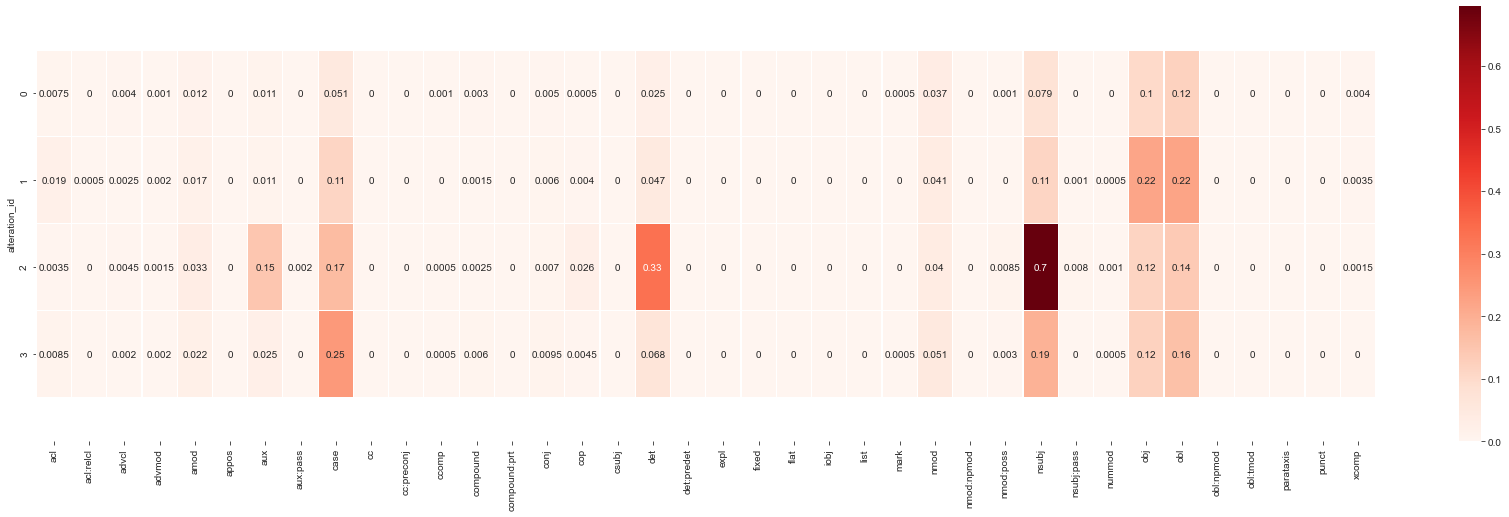

In [ ]:
from disentanglement_transformer_extended.models import get_hm_array2, plt
import pandas as pd

plt.figure(figsize=(30, 8))
print(pd.DataFrame(enc_var_wise_scores))
print(dec_var_wise_scores)
get_hm_array2(pd.DataFrame(enc_var_wise_scores).drop(['ROOT'], axis=1)
              , "enc_heatmap_ud.eps")
get_hm_array2(dec_var_wise_scores.drop(['ROOT', 'syntemp', 'lextemp'], axis=1)
              , "dec_heatmap_ud.eps")

In [6]:
import pandas as pd
from tqdm import tqdm
      
import spacy
nlp = spacy.load("en_core_web_sm")


def shallow_constituents(sents, verbose=0):
    target = [{'sentence': sent} for sent in sents]
    preds = const_predictor.predict_batch_json(target)
    outputs = []
    for pred in preds:
        root_c = pred['hierplane_tree']['root']['children']
        subj, verb, np, pp = '', '', '', ''
        parsing_error = False
        try:
            subj = [c['word'] for c in root_c if c['nodeType']=='NP'][0]
            VP_c = [c for c in root_c if c['nodeType']=='VP'][0]['children']
            if not any([c['nodeType'].startswith('VB') for c in VP_c]):
                outputs.append({'subj':subj, 'verb':'', 'np':'', 'pp':''})
                continue
            verb = [c['word'] for c in VP_c if c['nodeType'].startswith('VB')][0]
            
            np = [c['word'] for c in VP_c if c['nodeType']=='NP'][0] if any([c['nodeType']=='NP' for c in VP_c]) else ''
            pp = [c['word'] for c in VP_c if c['nodeType']=='PP'][0] if any([c['nodeType']=='PP' for c in VP_c]) else ''
            if verbose: 
                print([[c['nodeType'],c['word']] for c in VP_c])
            while any([c['nodeType'] == 'VP' for c in VP_c]):
                VP_c = [c for c in VP_c if c['nodeType']=='VP'][0]['children']
                if verbose: 
                    print([[c['nodeType'],c['word']] for c in VP_c])
                verb += ' '+[c['word'] for c in VP_c if c['nodeType'].startswith('VB')][0]
                if any([c['nodeType']=='NP' for c in VP_c]):
                    for np_i in [c['word'] for c in VP_c if c['nodeType']=='NP']:
                        np += ' '+np_i
                if any([c['nodeType']=='PP' for c in VP_c]):
                    for pp_i in [c['word'] for c in VP_c if c['nodeType']=='PP']:
                        pp += ' '+pp_i
        except IndexError:
            parsing_error = True
        outputs.append({'subj':subj, 'verb':verb, 'np':np, 'pp':pp, 'err': parsing_error})
    return outputs

def shallow_dependencies(sents):
    docs = nlp.pipe(sents)
    relations = []
    for doc in docs:
        subj, verb, dobj, pobj = ['', []], ['', []], ['', []], ['', []]
        for i, tok in enumerate(doc):
            if tok.dep_ =='ROOT':
                verb = [tok.text, [tok.i]]
            if tok.dep_ == 'nsubj' and subj[0] == '':
                subj = [' '.join([toki.text for toki in tok.subtree]), [toki.i for toki in tok.subtree]]
            if tok.dep_ == 'dobj' and dobj[0] == '':
                dobj = [' '.join([toki.text for toki in tok.subtree]), [toki.i for toki in tok.subtree]]
            if tok.dep_ == 'pobj' and pobj[0] == '':
                pobj = [' '.join([toki.text for toki in tok.subtree]), [toki.i for toki in tok.subtree]]
        relations.append({'text':{'subj': subj[0], 'verb': verb[0], 'dobj': dobj[0], 'pobj': pobj[0]},
                         'idx':{'subj': subj[1], 'verb': verb[1], 'dobj': dobj[1], 'pobj': pobj[1]}})
    return relations

def get_sentence_statistics(orig, sen, orig_relations=None, relations=None):
    same_struct = True
    error = orig_relations.pop('err', None) or relations.pop('err', None)
    for k in orig_relations.keys():
        if (orig_relations[k] == '' and relations[k] != '') or (orig_relations[k] == '' and relations[k] != ''):
            same_struct = False
    def get_diff(arg):
        if orig_relations[arg] != '' and relations[arg] != '':
            return orig_relations[arg] != relations[arg], False
        else: 
            return False, orig_relations[arg] != relations[arg]
    return get_diff('subj'), get_diff('verb'), get_diff('np'), get_diff('pp'), same_struct, error
    # return get_diff('ARG0'), get_diff('V'), get_diff('ARG1'), get_diff('ARG*'), same_struct

def get_sentence_statistics2(orig, sen, orig_relations=None, relations=None):
    orig_relations, relations = orig_relations['text'], relations['text']
    same_struct = True
    for k in orig_relations.keys():
        if (orig_relations[k] == '' and relations[k] != '') or (orig_relations[k] == '' and relations[k] != ''):
            same_struct = False
    def get_diff(arg):
        if orig_relations[arg] != '' and relations[arg] != '':
            return orig_relations[arg] != relations[arg], False
        else: 
            return False, orig_relations[arg] != relations[arg]
    return get_diff('subj'), get_diff('verb'), get_diff('dobj'), get_diff('pobj'), same_struct



def _get_stat_data_frame(model, n_samples=20, n_alterations=10, batch_size=10):
    stats = []
    nlatents = model.h_params.n_latents
    # Generating n_samples sentences    
    text, samples, _ = model.get_sentences(n_samples=batch_size, gen_len=model.h_params.max_len-1,
                                                sample_w=False, vary_z=True, complete=None)
    orig_rels = shallow_dependencies(text)
    for _ in tqdm(range(int(n_samples / batch_size)), desc="Generating original sentences"):
        text_i, samples_i, _ = model.get_sentences(n_samples=batch_size, gen_len=model.h_params.max_len-1,
                                                    sample_w=False, vary_z=True, complete=None)
        text.extend(text_i)
        for k in samples.keys():
            samples[k] = torch.cat([samples[k], samples_i[k]])
        orig_rels.extend(shallow_dependencies(text_i))
    for i in range(int(n_samples / batch_size)):
        for j in tqdm(range(sum(nlatents)), desc="Processing sample {}".format(str(i))):
            # Altering the sentences
            alt_text, _ = model._get_alternative_sentences(
                                                       prev_latent_vals={k: v[i * batch_size:(i + 1) * batch_size]
                                                                         for k, v in samples.items()},
                                                       params=None, var_z_ids=[j], n_samples=n_alterations,
                                                       gen_len=model.h_params.max_len-1, complete=None)
            alt_rels = shallow_dependencies(alt_text)
            # Getting alteration statistics
            for k in range(n_alterations * batch_size):
                orig_text = text[(i * batch_size) + k % batch_size]
                try:
                    arg0_diff, v_diff, arg1_diff, arg_star_diff, same_struct = \
                        get_sentence_statistics2(orig_text, alt_text[k], orig_rels[(i * batch_size) + k % batch_size],
                                                alt_rels[k])
                except RecursionError or IndexError:
                    continue
                stats.append([orig_text, alt_text[k], j, int(arg0_diff[0]), int(v_diff[0]), 
                              int(arg1_diff[0]), int(arg_star_diff[0]), int(arg0_diff[1]), int(v_diff[1]), 
                              int(arg1_diff[1]), int(arg_star_diff[1]), same_struct])

    header = ['original', 'altered', 'alteration_id', 'subj_diff', 'verb_diff', 'dobj_diff', 'pobj_diff',
              'subj_struct', 'verb_struct', 'dobj_struct', 'pobj_struct', 'same_struct']
    df = pd.DataFrame(stats, columns=header)
    return df 


In [5]:

ex_sens = ['The man is breathing', "a group of people gave the boy a bike in summer"]
rels = batch_sent_relations(ex_sens)
print(rels)
for arg in ['ARG0', 'V', 'ARG1']:
    print(arg, ':', rels[0][arg]==rels[1][arg])

NameError: name 'batch_sent_relations' is not defined

In [6]:
df = _get_stat_data_frame(model, n_samples=2000, n_alterations=1, batch_size=100)
model.infer_bn.clear_values()
model.gen_bn.clear_values()

RuntimeError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 6.00 GiB total capacity; 497.50 MiB already allocated; 3.93 GiB free; 544.00 MiB reserved in total by PyTorch)

In [49]:
print(len(df))
scores = []
div_by = 5
for i in range(div_by):
    grouped_diff = df[int(i*len(df)/div_by):int((i+1)*len(df)/div_by)].groupby('alteration_id').mean()
    [['subj_diff', 'verb_diff', 'dobj_diff', 'pobj_diff']]
    # print(grouped_diff)#
    disent_score = 0
    for lab in ['subj_diff', 'verb_diff', 'dobj_diff', 'pobj_diff']:
        top2 = np.array(grouped_diff.nlargest(2, lab)[lab])
        diff = top2[0]-top2[1]
        # print(lab, diff)
        disent_score += diff
    print("Disentanglement score", disent_score)
    scores.append(disent_score)
print(np.mean(scores), np.std(scores))
grouped_diff = df.groupby('alteration_id').mean()[['subj_diff', 'verb_diff', 'dobj_diff', 'pobj_diff']]
print(grouped_diff)#
disent_score = 0
for lab in ['subj_diff', 'verb_diff', 'dobj_diff', 'pobj_diff']:
    top2 = np.array(grouped_diff.nlargest(2, lab)[lab])
    diff = top2[0]-top2[1]
    # print(lab, diff)
    disent_score += diff
print("Disentanglement score", disent_score)

df_fix = df[df['same_struct']==True]
print("Number of fixed structure pairs:", len(df_fix))
grouped_diff = df_fix.groupby('alteration_id').mean()[['subj_diff', 'verb_diff', 'dobj_diff', 'pobj_diff']]
print(grouped_diff)#
disent_score = 0
for lab in ['subj_diff', 'verb_diff', 'dobj_diff', 'pobj_diff']:#, 'arg_star_diff']:
    highest_idx = grouped_diff[lab].argmax()
    top2 = np.array(grouped_diff.nlargest(2, lab)[lab])
    diff = top2[0]-top2[1]
    print(lab, highest_idx, diff)
    disent_score += diff
    #grouped_diff = grouped_diff.drop(highest_idx)
print("Disentanglement score", disent_score)

8000
Disentanglement score 0.4224999999999999
Disentanglement score 0.39999999999999997
Disentanglement score 0.3625000000000001
Disentanglement score 0.4574999999999999
Disentanglement score 0.43500000000000005
0.4154999999999999 0.0323805497173843
               subj_diff  verb_diff  dobj_diff  pobj_diff
alteration_id                                            
0                 0.4305     0.8855     0.1885     0.2410
1                 0.4125     0.6960     0.2260     0.3030
2                 0.4045     0.6700     0.2180     0.2705
3                 0.6635     0.7305     0.2045     0.2800
Disentanglement score 0.4189999999999999
Number of fixed structure pairs: 4558
               subj_diff  verb_diff  dobj_diff  pobj_diff
alteration_id                                            
0               0.436563   0.830170   0.331668   0.402597
1               0.407807   0.584718   0.335548   0.438538
2               0.415776   0.552999   0.314708   0.394412
3               0.666373   0.6073

In [7]:
from components.links import CoattentiveTransformerLink, ConditionalCoattentiveTransformerLink
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


def get_attention_weights(sentences, lvs):
    # Encoding sentences
    encoded = []
    lens = []
    for sen in sentences:
        sen_enc = [data.vocab.stoi[w] for w in sen.split(' ')]
        lens.append(min(len(sen_enc), MAX_LEN))
        if len(sen_enc)>=MAX_LEN:
            sen_enc = sen_enc[:MAX_LEN]
        else:
            sen_enc = sen_enc+[data.vocab.stoi['<pad>']]*(MAX_LEN-len(sen_enc))
        encoded.append(sen_enc)
    encoded = torch.Tensor(encoded).to(DEVICE).long()
    lens = torch.Tensor(lens).to(DEVICE).long()
    CoattentiveTransformerLink.get_att, ConditionalCoattentiveTransformerLink.get_att = True, True
    model.infer_bn({'x': encoded}, lens=lens)
    CoattentiveTransformerLink.get_att, ConditionalCoattentiveTransformerLink.get_att = False, False
    all_att_weights = []
    for i in range(len(h_params.n_latents)):
        trans_mod = model.infer_bn.approximator[model.infer_bn.name_to_v['z{}'.format(i+1)]]
        all_att_weights.append(trans_mod.att_vals)
    att_weights = []
    for lv in lvs:
        var_att_weights = []
        lv_layer = sum([lv > sum(h_params.n_latents[:i+1]) for i in range(len(h_params.n_latents))])
        rank = lv - sum(h_params.n_latents[:lv_layer])
        for layer_att_vals in all_att_weights[lv_layer]:
            soft_att_vals = layer_att_vals
            att_out = torch.cat([soft_att_vals[:, rank, :MAX_LEN], soft_att_vals[:, rank, MAX_LEN:].sum(-1).unsqueeze(-1)]
                                , -1)
            if lv_layer==2:
                att_out[..., -1] *= 0
            var_att_weights.append(att_out.cpu().detach().numpy())
        att_weights.append(var_att_weights)
    return np.transpose(np.array(att_weights), (2, 0, 1, 3))

def display_attention(sentence, att_weights, variables):
    toked = sentence.split(' ')
    toked += ['<pad>']*(MAX_LEN-len(toked))+['<latent>']
    index = []
    for i in range(len(variables)):
        for j in range(len(att_weights[i])):
            index.append(str(variables[i])+'_'+str(j))
    att_weights = att_weights.reshape(-1, MAX_LEN+1)
    data = pd.DataFrame(att_weights#[:, :len(toked)].reshape((len(att_weights), len(toked)))
                        , columns=toked, index=index)
    sns_plot = plt.figure(figsize=(15, 2.8))
    ax = plt.axes()
    g = sns.heatmap(data, annot=True, yticklabels=True, ax=ax)
    ax.set_title('')
    for tick in g.get_xticklabels():
        tick.set_color('black')
    for tick in g.get_yticklabels():
        tick.set_color('black')
    g.set_ylim([0, len(index)])
    #g.set_xticklabels(data.axes[1], rotation=55, ha="center", labelcolor='white')
    # g.get_figure()
    # plt.show()
    return sns_plot


sentences = ['a man is standing .',
             'two little girls are standing .',
             "a girl is holding a toy", 
              "a girl with a white hat is holding a toy .", 
              "a girl is playing in a street", "a girl with a black coat is playing in a street .", 
             "a girl and a boy are playing in the street .",
             'a group of people are sitting around a table .']
vars = [0, 1, 2, 3]
att_w = get_attention_weights(sentences, vars)
print(att_w.shape)

# for sen_idx in range(len(sentences)):
#     sns_plot = display_attention(sentences[sen_idx], att_w[sen_idx], vars)
#     sns_plot.savefig("att_{}.png".format(sen_idx)) 

(8, 4, 2, 18)


In [19]:
from tqdm import tqdm
from disentanglement_transformer_extended.models import shallow_dependencies
def get_att_and_rel_idx(self, text_in, layer_num=None):
    max_len = text_in.shape[-1]
    text_sents = [' '.join([self.index[self.generated_v].itos[w]
                            for w in s]).replace(' <pad>', '').replace(' <eos>', '')
                  for s in text_in]
    # Getting relations' positions
    rel_idx = [out['idx'] for out in shallow_dependencies(text_sents)]
    # Getting layer wise attention values

    CoattentiveTransformerLink.get_att, ConditionalCoattentiveTransformerLink.get_att = True, True
    self.infer_bn({'x': text_in})
    CoattentiveTransformerLink.get_att, ConditionalCoattentiveTransformerLink.get_att = False, False
    all_att_weights = []
    for i in range(len(self.h_params.n_latents)):
        trans_mod = self.infer_bn.approximator[self.infer_bn.name_to_v['z{}'.format(i + 1)]]
        all_att_weights.append(trans_mod.att_vals)
    att_weights = []
    for lv in range(sum(self.h_params.n_latents)):
        var_att_weights = []
        lv_layer = sum([lv >= sum(self.h_params.n_latents[:i + 1]) for i in range(len(self.h_params.n_latents))])
        rank = lv - sum(self.h_params.n_latents[:lv_layer])
        for layer_att_vals in all_att_weights[lv_layer]:
            soft_att_vals = layer_att_vals
            att_out = torch.cat([soft_att_vals[:, rank,
                                 :max_len], soft_att_vals[:, rank, max_len:].sum(-1).unsqueeze(-1)]
                                , -1)
            if lv_layer == 2:  # TODO: update this part for structured inference networks
                att_out[..., -1] *= 0
            var_att_weights.append(att_out.cpu().detach().numpy())
        att_weights.append(var_att_weights)
    # att_vals shape:[sent, lv, layer, tok]
    if layer_num is None:
        att_vals = np.transpose(np.array(att_weights), (2, 0, 1, 3)).mean(-2)
    else:
        att_vals = np.transpose(np.array(att_weights), (2, 0, 1, 3))[:, :, layer_num, :]
    att_maxes = att_vals.argmax(-1).tolist()
    return rel_idx, att_maxes

def get_encoder_disentanglement_score(self, data_iter, layer_num=None):
    rel_idx, att_maxes = [], []
    for i, batch in enumerate(tqdm(data_iter, desc="Getting model relationship accuracy")):
        rel_idx_i, att_maxes_i = get_att_and_rel_idx(self, batch.text[..., 1:], layer_num=layer_num)
        rel_idx.extend(rel_idx_i)
        att_maxes.extend(att_maxes_i)

    lv_scores = []
    for lv in range(sum(self.h_params.n_latents)):
        found = {'subj': [], 'verb': [], 'dobj': [], 'pobj': []}
        for att, rel_pos in zip(att_maxes, rel_idx):
            for k in found.keys():
                if len(rel_pos[k]):
                    found[k].append(att[lv] in rel_pos[k])
        lv_scores.append(found)
    enc_att_scores = {'subj': [], 'verb': [], 'dobj': [], 'pobj': []}
    for lv in range(sum(self.h_params.n_latents)):
        for k, v in lv_scores[lv].items():
            enc_att_scores[k].append(np.mean(v))

    enc_max_score, enc_disent_score, enc_disent_vars = {}, {}, {}
    for k, v in enc_att_scores.items():
        sort_idx = np.argsort(v)
        enc_disent_vars[k], enc_disent_score[k], enc_max_score[k] = \
            sort_idx[-1], v[sort_idx[-1]] - v[sort_idx[-2]], v[sort_idx[-1]]
    return enc_att_scores, enc_max_score, enc_disent_score, enc_disent_vars

In [2]:
# att_scores0, max_score0, disent_score0, disent_vars0 = get_encoder_disentanglement_score(model, data.val_iter, layer_num=0)
# att_scores1, max_score1, disent_score1, disent_vars1 = get_encoder_disentanglement_score(model, data.val_iter, layer_num=1)
att_scores_mean, max_score_mean, disent_score_mean, disent_vars_mean = model.get_encoder_disentanglement_score(data.val_iter)
# att_scores_mean, max_score_mean, disent_score_mean, disent_vars_mean = get_encoder_disentanglement_score(model, data.val_iter, layer_num=None)


Getting model relationship accuracy:   0%|          | 0/417 [00:00<?, ?it/s]

Getting model relationship accuracy:   0%|          | 1/417 [00:00<02:21,  2.94it/s]

Getting model relationship accuracy:   1%|          | 4/417 [00:00<01:43,  3.97it/s]

Getting model relationship accuracy:   2%|▏         | 7/417 [00:00<01:17,  5.28it/s]

Getting model relationship accuracy:   2%|▏         | 10/417 [00:00<00:59,  6.86it/s]

Getting model relationship accuracy:   3%|▎         | 13/417 [00:00<00:46,  8.73it/s]

Getting model relationship accuracy:   4%|▍         | 16/417 [00:00<00:37, 10.79it/s]

Getting model relationship accuracy:   5%|▍         | 19/417 [00:01<00:31, 12.73it/s]

Getting model relationship accuracy:   5%|▌         | 22/417 [00:01<00:26, 14.68it/s]

Getting model relationship accuracy:   6%|▌         | 25/417 [00:01<00:23, 16.70it/s]

Getting model relationship accuracy:   7%|▋         | 28/417 [00:01<00:21, 18.24it/s]

Getting model relationship accuracy:   7%|▋         | 31/417 [00:01<00:19, 19.51it/s]

Getting model relationship accuracy:   8%|▊         | 34/417 [00:01<00:18, 20.67it/s]

Getting model relationship accuracy:   9%|▉         | 37/417 [00:01<00:18, 20.67it/s]

Getting model relationship accuracy:  10%|▉         | 40/417 [00:02<00:17, 20.98it/s]

Getting model relationship accuracy:  10%|█         | 43/417 [00:02<00:17, 21.66it/s]

Getting model relationship accuracy:  11%|█         | 46/417 [00:02<00:16, 22.12it/s]

Getting model relationship accuracy:  12%|█▏        | 49/417 [00:02<00:16, 22.25it/s]

Getting model relationship accuracy:  12%|█▏        | 52/417 [00:02<00:15, 23.01it/s]

Getting model relationship accuracy:  13%|█▎        | 55/417 [00:02<00:15, 23.03it/s]

Getting model relationship accuracy:  14%|█▍        | 58/417 [00:02<00:15, 22.88it/s]

Getting model relationship accuracy:  15%|█▍        | 61/417 [00:02<00:15, 22.58it/s]

Getting model relationship accuracy:  15%|█▌        | 64/417 [00:03<00:15, 22.88it/s]

Getting model relationship accuracy:  16%|█▌        | 67/417 [00:03<00:15, 23.10it/s]

Getting model relationship accuracy:  17%|█▋        | 70/417 [00:03<00:14, 23.15it/s]

Getting model relationship accuracy:  18%|█▊        | 73/417 [00:03<00:15, 22.05it/s]

Getting model relationship accuracy:  18%|█▊        | 76/417 [00:03<00:16, 21.08it/s]

Getting model relationship accuracy:  19%|█▉        | 79/417 [00:03<00:15, 21.59it/s]

Getting model relationship accuracy:  20%|█▉        | 82/417 [00:03<00:16, 20.74it/s]

Getting model relationship accuracy:  20%|██        | 85/417 [00:04<00:16, 19.94it/s]

Getting model relationship accuracy:  21%|██        | 88/417 [00:04<00:16, 19.45it/s]

Getting model relationship accuracy:  22%|██▏       | 90/417 [00:04<00:17, 18.58it/s]

Getting model relationship accuracy:  22%|██▏       | 92/417 [00:04<00:18, 17.91it/s]

Getting model relationship accuracy:  23%|██▎       | 94/417 [00:04<00:18, 17.89it/s]

Getting model relationship accuracy:  23%|██▎       | 96/417 [00:04<00:17, 18.03it/s]

Getting model relationship accuracy:  24%|██▎       | 98/417 [00:04<00:17, 18.17it/s]

Getting model relationship accuracy:  24%|██▍       | 100/417 [00:04<00:17, 17.74it/s]

Getting model relationship accuracy:  24%|██▍       | 102/417 [00:05<00:17, 17.92it/s]

Getting model relationship accuracy:  25%|██▌       | 105/417 [00:05<00:16, 18.63it/s]

Getting model relationship accuracy:  26%|██▌       | 107/417 [00:05<00:16, 19.02it/s]

Getting model relationship accuracy:  26%|██▋       | 110/417 [00:05<00:15, 19.73it/s]

Getting model relationship accuracy:  27%|██▋       | 113/417 [00:05<00:14, 20.29it/s]

Getting model relationship accuracy:  28%|██▊       | 116/417 [00:05<00:14, 21.19it/s]

Getting model relationship accuracy:  29%|██▊       | 119/417 [00:05<00:14, 21.08it/s]

Getting model relationship accuracy:  29%|██▉       | 122/417 [00:05<00:13, 21.41it/s]

Getting model relationship accuracy:  30%|██▉       | 125/417 [00:06<00:13, 21.93it/s]

Getting model relationship accuracy:  31%|███       | 128/417 [00:06<00:13, 22.16it/s]

Getting model relationship accuracy:  31%|███▏      | 131/417 [00:06<00:12, 22.08it/s]

Getting model relationship accuracy:  32%|███▏      | 134/417 [00:06<00:12, 21.93it/s]

Getting model relationship accuracy:  33%|███▎      | 137/417 [00:06<00:13, 20.28it/s]

Getting model relationship accuracy:  34%|███▎      | 140/417 [00:06<00:14, 19.48it/s]

Getting model relationship accuracy:  34%|███▍      | 142/417 [00:07<00:15, 17.75it/s]

Getting model relationship accuracy:  35%|███▍      | 144/417 [00:07<00:14, 18.27it/s]

Getting model relationship accuracy:  35%|███▌      | 147/417 [00:07<00:14, 19.08it/s]

Getting model relationship accuracy:  36%|███▌      | 149/417 [00:07<00:13, 19.24it/s]

Getting model relationship accuracy:  36%|███▌      | 151/417 [00:07<00:14, 18.18it/s]

Getting model relationship accuracy:  37%|███▋      | 154/417 [00:07<00:13, 18.91it/s]

Getting model relationship accuracy:  38%|███▊      | 157/417 [00:07<00:13, 19.71it/s]

Getting model relationship accuracy:  38%|███▊      | 160/417 [00:07<00:12, 19.88it/s]

Getting model relationship accuracy:  39%|███▉      | 163/417 [00:08<00:12, 19.84it/s]

Getting model relationship accuracy:  40%|███▉      | 165/417 [00:08<00:13, 19.36it/s]

Getting model relationship accuracy:  40%|████      | 167/417 [00:08<00:13, 19.21it/s]

Getting model relationship accuracy:  41%|████      | 169/417 [00:08<00:13, 18.42it/s]

Getting model relationship accuracy:  41%|████      | 172/417 [00:08<00:12, 19.61it/s]

Getting model relationship accuracy:  42%|████▏     | 175/417 [00:08<00:11, 20.83it/s]

Getting model relationship accuracy:  43%|████▎     | 178/417 [00:08<00:11, 20.96it/s]

Getting model relationship accuracy:  43%|████▎     | 181/417 [00:08<00:11, 21.15it/s]

Getting model relationship accuracy:  44%|████▍     | 184/417 [00:09<00:11, 21.14it/s]

Getting model relationship accuracy:  45%|████▍     | 187/417 [00:09<00:11, 20.83it/s]

Getting model relationship accuracy:  46%|████▌     | 190/417 [00:09<00:10, 20.87it/s]

Getting model relationship accuracy:  46%|████▋     | 193/417 [00:09<00:10, 21.22it/s]

Getting model relationship accuracy:  47%|████▋     | 196/417 [00:09<00:10, 20.71it/s]

Getting model relationship accuracy:  48%|████▊     | 199/417 [00:09<00:10, 20.16it/s]

Getting model relationship accuracy:  48%|████▊     | 202/417 [00:09<00:10, 20.69it/s]

Getting model relationship accuracy:  49%|████▉     | 205/417 [00:10<00:09, 21.36it/s]

Getting model relationship accuracy:  50%|████▉     | 208/417 [00:10<00:09, 22.09it/s]

Getting model relationship accuracy:  51%|█████     | 211/417 [00:10<00:09, 22.58it/s]

Getting model relationship accuracy:  51%|█████▏    | 214/417 [00:10<00:08, 22.98it/s]

Getting model relationship accuracy:  52%|█████▏    | 217/417 [00:10<00:08, 22.70it/s]

Getting model relationship accuracy:  53%|█████▎    | 220/417 [00:10<00:08, 22.71it/s]

Getting model relationship accuracy:  53%|█████▎    | 223/417 [00:10<00:08, 23.03it/s]

Getting model relationship accuracy:  54%|█████▍    | 226/417 [00:10<00:08, 23.36it/s]

Getting model relationship accuracy:  55%|█████▍    | 229/417 [00:11<00:08, 23.28it/s]

Getting model relationship accuracy:  56%|█████▌    | 232/417 [00:11<00:07, 23.43it/s]

Getting model relationship accuracy:  56%|█████▋    | 235/417 [00:11<00:07, 23.60it/s]

Getting model relationship accuracy:  57%|█████▋    | 238/417 [00:11<00:07, 23.55it/s]

Getting model relationship accuracy:  58%|█████▊    | 241/417 [00:11<00:07, 23.19it/s]

Getting model relationship accuracy:  59%|█████▊    | 244/417 [00:11<00:07, 23.43it/s]

Getting model relationship accuracy:  59%|█████▉    | 247/417 [00:11<00:07, 23.27it/s]

Getting model relationship accuracy:  60%|█████▉    | 250/417 [00:11<00:07, 23.59it/s]

Getting model relationship accuracy:  61%|██████    | 253/417 [00:12<00:06, 23.44it/s]

Getting model relationship accuracy:  61%|██████▏   | 256/417 [00:12<00:06, 23.77it/s]

Getting model relationship accuracy:  62%|██████▏   | 259/417 [00:12<00:06, 23.50it/s]

Getting model relationship accuracy:  63%|██████▎   | 262/417 [00:12<00:06, 23.54it/s]

Getting model relationship accuracy:  64%|██████▎   | 265/417 [00:12<00:06, 22.81it/s]

Getting model relationship accuracy:  64%|██████▍   | 268/417 [00:12<00:06, 23.05it/s]

Getting model relationship accuracy:  65%|██████▍   | 271/417 [00:12<00:06, 22.85it/s]

Getting model relationship accuracy:  66%|██████▌   | 274/417 [00:13<00:06, 22.86it/s]

Getting model relationship accuracy:  66%|██████▋   | 277/417 [00:13<00:05, 23.52it/s]

Getting model relationship accuracy:  67%|██████▋   | 280/417 [00:13<00:05, 23.89it/s]

Getting model relationship accuracy:  68%|██████▊   | 283/417 [00:13<00:05, 24.45it/s]

Getting model relationship accuracy:  69%|██████▊   | 286/417 [00:13<00:05, 24.79it/s]

Getting model relationship accuracy:  69%|██████▉   | 289/417 [00:13<00:05, 24.92it/s]

Getting model relationship accuracy:  70%|███████   | 292/417 [00:13<00:04, 25.19it/s]

Getting model relationship accuracy:  71%|███████   | 295/417 [00:13<00:04, 25.14it/s]

Getting model relationship accuracy:  71%|███████▏  | 298/417 [00:13<00:04, 25.28it/s]

Getting model relationship accuracy:  72%|███████▏  | 301/417 [00:14<00:04, 24.89it/s]

Getting model relationship accuracy:  73%|███████▎  | 304/417 [00:14<00:04, 24.67it/s]

Getting model relationship accuracy:  74%|███████▎  | 307/417 [00:14<00:04, 24.83it/s]

Getting model relationship accuracy:  74%|███████▍  | 310/417 [00:14<00:04, 24.52it/s]

Getting model relationship accuracy:  75%|███████▌  | 313/417 [00:14<00:04, 24.36it/s]

Getting model relationship accuracy:  76%|███████▌  | 316/417 [00:14<00:04, 24.79it/s]

Getting model relationship accuracy:  76%|███████▋  | 319/417 [00:14<00:03, 25.23it/s]

Getting model relationship accuracy:  77%|███████▋  | 322/417 [00:14<00:03, 24.97it/s]

Getting model relationship accuracy:  78%|███████▊  | 325/417 [00:15<00:03, 25.42it/s]

Getting model relationship accuracy:  79%|███████▊  | 328/417 [00:15<00:03, 25.03it/s]

Getting model relationship accuracy:  79%|███████▉  | 331/417 [00:15<00:03, 25.40it/s]

Getting model relationship accuracy:  80%|████████  | 334/417 [00:15<00:03, 25.60it/s]

Getting model relationship accuracy:  81%|████████  | 337/417 [00:15<00:03, 25.61it/s]

Getting model relationship accuracy:  82%|████████▏ | 340/417 [00:15<00:02, 25.75it/s]

Getting model relationship accuracy:  82%|████████▏ | 343/417 [00:15<00:02, 25.92it/s]

Getting model relationship accuracy:  83%|████████▎ | 346/417 [00:15<00:02, 25.70it/s]

Getting model relationship accuracy:  84%|████████▎ | 349/417 [00:15<00:02, 25.10it/s]

Getting model relationship accuracy:  84%|████████▍ | 352/417 [00:16<00:02, 25.33it/s]

Getting model relationship accuracy:  85%|████████▌ | 355/417 [00:16<00:02, 25.42it/s]

Getting model relationship accuracy:  86%|████████▌ | 358/417 [00:16<00:02, 25.36it/s]

Getting model relationship accuracy:  87%|████████▋ | 361/417 [00:16<00:02, 25.70it/s]

Getting model relationship accuracy:  87%|████████▋ | 364/417 [00:16<00:02, 25.82it/s]

Getting model relationship accuracy:  88%|████████▊ | 367/417 [00:16<00:01, 25.76it/s]

Getting model relationship accuracy:  89%|████████▊ | 370/417 [00:16<00:01, 25.86it/s]

Getting model relationship accuracy:  89%|████████▉ | 373/417 [00:16<00:01, 25.34it/s]

Getting model relationship accuracy:  90%|█████████ | 376/417 [00:17<00:01, 25.56it/s]

Getting model relationship accuracy:  91%|█████████ | 379/417 [00:17<00:01, 25.65it/s]

Getting model relationship accuracy:  92%|█████████▏| 382/417 [00:17<00:01, 25.84it/s]

Getting model relationship accuracy:  92%|█████████▏| 385/417 [00:17<00:01, 25.98it/s]

Getting model relationship accuracy:  93%|█████████▎| 388/417 [00:17<00:01, 25.68it/s]

Getting model relationship accuracy:  94%|█████████▍| 391/417 [00:17<00:01, 25.47it/s]

Getting model relationship accuracy:  94%|█████████▍| 394/417 [00:17<00:00, 25.59it/s]

Getting model relationship accuracy:  95%|█████████▌| 397/417 [00:17<00:00, 25.22it/s]

Getting model relationship accuracy:  96%|█████████▌| 400/417 [00:17<00:00, 25.60it/s]

Getting model relationship accuracy:  97%|█████████▋| 403/417 [00:18<00:00, 25.61it/s]

Getting model relationship accuracy:  97%|█████████▋| 406/417 [00:18<00:00, 25.23it/s]

Getting model relationship accuracy:  98%|█████████▊| 409/417 [00:18<00:00, 25.16it/s]

Getting model relationship accuracy:  99%|█████████▉| 412/417 [00:18<00:00, 25.24it/s]

Getting model relationship accuracy: 100%|█████████▉| 415/417 [00:18<00:00, 25.42it/s]

Getting model relationship accuracy: 100%|██████████| 417/417 [00:18<00:00, 22.35it/s]

      nsubj      verb      dobj      pobj
0  0.003753  0.007431  0.129081  0.348315
1  0.032412  0.090468  0.546697  0.670853
2  0.785397  0.099192  0.000000  0.000000
3  0.145002  0.512763  0.312073  0.078652
1.611128193750011 {'nsubj': 2, 'verb': 3, 'dobj': 1, 'pobj': 1}


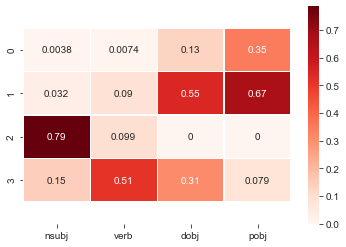

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
def show_df_hm2(df, fig_name):
    snsplt = sns.heatmap(df, cmap ='Reds', linewidths = 0.20, annot = True)#, vmin=0, vmax=1.0)
    # snsplt.get_figure().savefig(fig_name)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    # return snsplt.get_figure()
att_df = pd.DataFrame(att_scores_mean)
print(att_df)
show_df_hm2(att_df, "enc_heatmap_16.eps")
print(sum(disent_score_mean.values()), disent_vars_mean)

        subj      verb      dobj      pobj
0   0.003385  0.000323  0.009850  0.004630
1   0.086957  0.098546  0.010788  0.005247
2   0.003124  0.000000  0.014071  0.006790
3   0.002603  0.000000  0.011257  0.013889
4   0.884405  0.038449  0.001407  0.001235
5   0.068211  0.122779  0.597561  0.571296
6   0.248373  0.663974  0.081144  0.131173
7   0.014840  0.030695  0.256098  0.382407
8   0.976569  0.002585  0.000469  0.000309
9   0.003124  0.000000  0.019231  0.014198
10  0.108565  0.110501  0.014540  0.006481
11  0.004426  0.001292  0.085835  0.110185
12  0.054934  0.104039  0.004690  0.003086
13  0.007550  0.010985  0.128518  0.199691
14  0.002603  0.000000  0.007974  0.010494
15  0.003124  0.000000  0.020169  0.014506


1.1637112791869355 {'subj': 8, 'verb': 6, 'dobj': 5, 'pobj': 5}


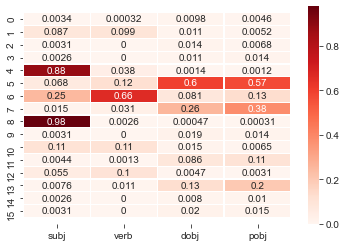

In [ ]:

for l_ind in range(3):
    fig_n = 'enc_layer_heatmap_{}.eps'.format(["0", "1", "mean"][l_ind])
    print(["============ layer 0 ==================",
           "============ layer 1 ==================",
           "============ layer mean =================="][l_ind])
    att_scores = [att_scores0, att_scores1, att_scores_mean][l_ind]
    disent_score = [disent_score0, disent_score1, disent_score_mean][l_ind]
    disent_vars = [disent_vars0, disent_vars1, disent_vars_mean][l_ind]
    print(sum(disent_score.values()), len(np.unique(list(disent_vars.values()))))
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.figure()
    def show_df_hm2(df, fig_name):
        snsplt = sns.heatmap(df, cmap ='Reds', linewidths = 0.20, annot = True, vmin=0, vmax=1.0)
        snsplt.get_figure().savefig(fig_name)
        b, t = plt.ylim() # discover the values for bottom and top
        b += 0.5 # Add 0.5 to the bottom
        t -= 0.5 # Subtract 0.5 from the top
        plt.ylim(b, t) # update the ylim(bottom, top) values
        # return snsplt.get_figure()
    att_df = pd.DataFrame(att_scores)
    print(att_df)
    show_df_hm2(att_df, fig_n)


In [30]:
from disentanglement_transformer_extended.models import truncated_template, shallow_dependencies, pd
from tqdm import tqdm
def _get_stat_data_frame2(self, n_samples=2000, n_alterations=1, batch_size=100, drop_struct=True):
    stats = []
    # Generating n_samples sentences
    text, samples, _ = self.get_sentences(n_samples=batch_size, gen_len=self.h_params.max_len - 1,
                                          sample_w=False, vary_z=True, complete=None)
    orig_rels = shallow_dependencies(text)
    orig_temps = truncated_template(text)
    for _ in tqdm(range(int(n_samples / batch_size)), desc="Generating original sentences"):
        text_i, samples_i, _ = self.get_sentences(n_samples=batch_size, gen_len=self.h_params.max_len - 1,
                                                  sample_w=False, vary_z=True, complete=None)
        text.extend(text_i)
        for k in samples.keys():
            samples[k] = torch.cat([samples[k], samples_i[k]])
        orig_rels.extend(shallow_dependencies(text_i))
        orig_temps.extend(truncated_template(text_i))
    for i in range(int(n_samples / batch_size)):
        for j in tqdm(range(sum(self.h_params.n_latents)), desc="Processing sample {}".format(str(i))):
            # Altering the sentences
            alt_text, _ = self._get_alternative_sentences(
                prev_latent_vals={k: v[i * batch_size:(i + 1) * batch_size]
                                  for k, v in samples.items()},
                params=None, var_z_ids=[j], n_samples=n_alterations,
                gen_len=self.h_params.max_len - 1, complete=None)
            alt_rels = shallow_dependencies(alt_text)
            alt_temps = truncated_template(alt_text)
            # Getting alteration statistics
            for k in range(n_alterations * batch_size):
                orig_text = text[(i * batch_size) + k % batch_size]
                try:
                    arg0_diff, v_diff, arg1_diff, arg_star_diff, same_struct, syn_temp_diff, lex_temp_diff = \
                        self.get_sentence_statistics2(orig_text, alt_text[k],
                                                      orig_rels[(i * batch_size) + k % batch_size], alt_rels[k],
                                                      orig_temps[(i * batch_size) + k % batch_size], alt_temps[k])
                except RecursionError or IndexError:
                    continue
                stats.append([orig_text, alt_text[k], j, int(arg0_diff[0]), int(v_diff[0]),
                              int(arg1_diff[0]), int(arg_star_diff[0]), int(arg0_diff[1]), int(v_diff[1]),
                              int(arg1_diff[1]), int(arg_star_diff[1]), same_struct, syn_temp_diff, lex_temp_diff])

    header = ['original', 'altered', 'alteration_id', 'subj_diff', 'verb_diff', 'dobj_diff', 'pobj_diff',
              'subj_struct', 'verb_struct', 'dobj_struct', 'pobj_struct', 'same_struct', 'syntemp_diff',
              'lextemp_diff']
    df = pd.DataFrame(stats, columns=header)
    if not drop_struct:
        for diff_lab, struct_lab in zip(['subj_diff', 'verb_diff', 'dobj_diff', 'pobj_diff'], 
                                        ['subj_struct', 'verb_struct', 'dobj_struct', 'pobj_struct']):
            df[diff_lab] = [d or s for d, s in zip(df[diff_lab], df[struct_lab])] 
    var_wise_scores = df.groupby('alteration_id').mean()[['subj_diff', 'verb_diff', 'dobj_diff', 'pobj_diff',
                                                          'syntemp_diff', 'lextemp_diff']]
    var_wise_scores_struct = df.groupby('alteration_id').mean()[['subj_struct', 'verb_struct',
                                                                 'dobj_struct', 'pobj_struct']]
    var_wise_scores.set_axis([a.split('_')[0] for a in var_wise_scores.axes[1]], axis=1, inplace=True)
    if drop_struct:
        # renormalizing
        struct_array = np.array(var_wise_scores_struct)
        struct_array = 1-np.concatenate([struct_array, np.zeros((sum(self.h_params.n_latents), 2))], axis=1)
        var_wise_scores = var_wise_scores/struct_array
    
    disent_score = 0
    lab_wise_disent = {}
    dec_disent_vars = {}
    for lab in ['subj', 'verb', 'dobj', 'pobj']:
        try:
            dec_disent_vars[lab] = var_wise_scores.idxmax()[lab]
        except TypeError:
            dec_disent_vars[lab] = -1
            lab_wise_disent[lab] = 0
            continue
        top2 = np.array(var_wise_scores.nlargest(2, lab)[lab])
        diff = top2[0] - top2[1]
        lab_wise_disent[lab] = diff
        disent_score += diff
    for lab in ['syntemp', 'lextemp']:
        try:
            var_wise_scores.idxmax()[lab]
        except TypeError:
            lab_wise_disent[lab] = 0
            continue
        top2 = np.array(var_wise_scores.nlargest(2, lab)[lab])
        diff = top2[0] - top2[1]
        lab_wise_disent[lab] = diff
    return disent_score, lab_wise_disent, var_wise_scores, dec_disent_vars, var_wise_scores_struct

In [5]:
# disent_score, lab_wise_disent, var_wise_scores, dec_disent_vars, var_wise_scores_struct = \
#     _get_stat_data_frame2(model, n_samples=200, n_alterations=1, batch_size=100)
from disentanglement_transformer_extended.models import shallow_dependencies2, nlp, truncated_template, tqdm
def _get_stat_data_frame2(self, n_samples=2000, n_alterations=1, batch_size=100, delta_drop=True):
        stats = []
        rels = ['nsubj', 'verb', 'dobj', 'pobj'] if self.dataset != "de_nli" else ['sb', 'verb', 'oa', 'da', 'op', 'oc']
        if self.dataset == 'de_nli':
            shall_dep_func = lambda x: shallow_dependencies2(x, de_nlp, ['sb', 'verb', 'oa', 'da', 'op', 'oc'])
        else:
            shall_dep_func = lambda x: shallow_dependencies2(x, nlp)
        # Generating n_samples sentences
        text, samples, _ = self.get_sentences(n_samples=batch_size, gen_len=self.h_params.max_len - 1,
                                              sample_w=False, vary_z=True, complete=None)
        orig_rels = shall_dep_func(text)
        orig_temps = truncated_template(text)
        for _ in tqdm(range(int(n_samples / batch_size)), desc="Generating original sentences"):
            text_i, samples_i, _ = self.get_sentences(n_samples=batch_size, gen_len=self.h_params.max_len - 1,
                                                      sample_w=False, vary_z=True, complete=None)
            text.extend(text_i)
            for k in samples.keys():
                samples[k] = torch.cat([samples[k], samples_i[k]])
            orig_rels.extend(shall_dep_func(text_i))
            orig_temps.extend(truncated_template(text_i))
        for i in range(int(n_samples / batch_size)):
            for j in tqdm(range(sum(self.h_params.n_latents)), desc="Processing sample {}".format(str(i))):
                # Altering the sentences
                alt_text, _ = self._get_alternative_sentences(
                    prev_latent_vals={k: v[i * batch_size:(i + 1) * batch_size]
                                      for k, v in samples.items()},
                    params=None, var_z_ids=[j], n_samples=n_alterations,
                    gen_len=self.h_params.max_len - 1, complete=None)
                alt_rels = shall_dep_func(alt_text)
                alt_temps = truncated_template(alt_text)
                # Getting alteration statistics
                for k in range(n_alterations * batch_size):
                    orig_text = text[(i * batch_size) + k % batch_size]
                    try:
                        r_diffs, same_struct, syn_temp_diff, lex_temp_diff = \
                            self.get_sentence_statistics2(orig_text, alt_text[k],
                                                          orig_rels[(i * batch_size) + k % batch_size], alt_rels[k],
                                                          orig_temps[(i * batch_size) + k % batch_size], alt_temps[k])
                    except RecursionError or IndexError:
                        continue
                    stats.append([orig_text, alt_text[k], j, *(int(diff[0]) for diff in r_diffs),
                                  *(int(diff[1]) for diff in r_diffs), same_struct, syn_temp_diff, lex_temp_diff])

        header = ['original', 'altered', 'alteration_id',*(r+"_diff" for r in rels), *(r+"_struct" for r in rels),
                  # 'subj_diff', 'verb_diff', 'dobj_diff', 'pobj_diff',
                  # 'subj_struct', 'verb_struct', 'dobj_struct', 'pobj_struct',
                  'same_struct', 'syntemp_diff',
                  'lextemp_diff']
        df = pd.DataFrame(stats, columns=header)
        if not delta_drop:
            for diff_lab, struct_lab in zip([r+"_diff" for r in rels], [r+"_struct" for r in rels]):
                df[diff_lab] = [d or s for d, s in zip(df[diff_lab], df[struct_lab])]
        var_wise_scores = df.groupby('alteration_id').mean()[[r+"_diff" for r in rels]+['syntemp_diff', 'lextemp_diff']]
        var_wise_scores_struct = df.groupby('alteration_id').mean()[[r+"_struct" for r in rels]]
        var_wise_scores.set_axis([a.split('_')[0] for a in var_wise_scores.axes[1]], axis=1, inplace=True)
        if delta_drop:
            # renormalizing
            struct_array = np.array(var_wise_scores_struct)
            struct_array = 1-np.concatenate([struct_array, np.zeros((sum(self.h_params.n_latents), 2))], axis=1)
            var_wise_scores = var_wise_scores/struct_array

        disent_score = 0
        lab_wise_disent = {}
        dec_disent_vars = {}
        for lab in rels:
            try:
                dec_disent_vars[lab] = var_wise_scores.idxmax()[lab]
            except TypeError:
                dec_disent_vars[lab] = -1
                lab_wise_disent[lab] = 0
                continue
            top2 = np.array(var_wise_scores.nlargest(2, lab)[lab])
            diff = top2[0] - top2[1]
            lab_wise_disent[lab] = diff
            disent_score += diff
        for lab in ['syntemp', 'lextemp']:
            try:
                var_wise_scores.idxmax()[lab]
            except TypeError:
                lab_wise_disent[lab] = 0
                continue
            top2 = np.array(var_wise_scores.nlargest(2, lab)[lab])
            diff = top2[0] - top2[1]
            lab_wise_disent[lab] = diff
        return disent_score, lab_wise_disent, var_wise_scores, dec_disent_vars
disent_score, lab_wise_disent, var_wise_scores, dec_disent_vars = \
    _get_stat_data_frame2(model, n_samples=200, n_alterations=1, batch_size=100)

Generating original sentences:   0%|          | 0/2 [00:00<?, ?it/s]

Generating original sentences:  50%|█████     | 1/2 [00:00<00:00,  1.69it/s]

Generating original sentences: 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

Generating original sentences: 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Processing sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 0:  25%|██▌       | 1/4 [00:00<00:01,  1.74it/s]

Processing sample 0:  50%|█████     | 2/4 [00:01<00:01,  1.78it/s]

Processing sample 0:  75%|███████▌  | 3/4 [00:01<00:00,  1.80it/s]

Processing sample 0: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

Processing sample 0: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Processing sample 1:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 1:  25%|██▌       | 1/4 [00:00<00:01,  1.52it/s]

Processing sample 1:  50%|█████     | 2/4 [00:01<00:01,  1.52it/s]

Processing sample 1:  75%|███████▌  | 3/4 [00:01<00:00,  1.50it/s]

Processing sample 1: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]

Processing sample 1: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

{'nsubj': 2, 'verb': 3, 'dobj': 1, 'pobj': 1}
0.9621411917325674
{'nsubj': 0.3573775243984925, 'verb': 0.37689593548091455, 'dobj': 0.12563303467082199, 'pobj': 0.10223469718233835, 'syntemp': 0.245, 'lextemp': 0.10999999999999999}
                  nsubj      verb      dobj      pobj
alteration_id                                        
0              0.042105  0.026455  0.084211  0.116022
1              0.048649  0.173913  0.264706  0.254777
2              0.525316  0.299363  0.139073  0.124183
3              0.167939  0.676259  0.138889  0.152542


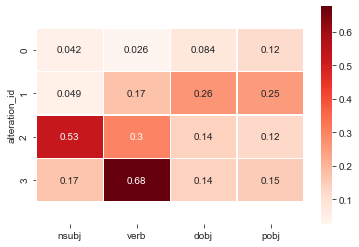

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
print(dec_disent_vars)
print(disent_score)
print(lab_wise_disent)
def show_df_hm2(df):
    snsplt = sns.heatmap(df, cmap ='Reds', linewidths = 0.20, annot = True)
    snsplt.get_figure().savefig("dec_heatmap_16.eps")
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    # return snsplt.get_figure()
to_show_dec_df = var_wise_scores.drop(['syntemp', 'lextemp'], axis=1)
print(to_show_dec_df)
show_df_hm2(to_show_dec_df)


0.9387009952613685
{'subj': 0.5575988419735771, 'verb': 0.3463679163290137, 'dobj': 0.028507490123428236, 'pobj': 0.0062267468353494615, 'syntemp': 0.134, 'lextemp': 0.07050000000000001}
               subj_struct  verb_struct  dobj_struct  pobj_struct
alteration_id                                                    
0                   0.0225       0.0520       0.0930       0.1300
1                   0.0460       0.0995       0.2010       0.2570
2                   0.1330       0.2475       0.3000       0.2675
3                   0.1020       0.3215       0.4315       0.3635


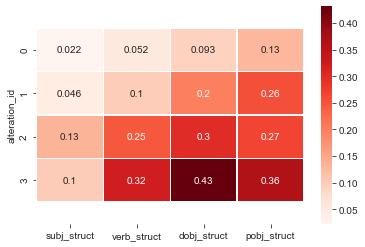

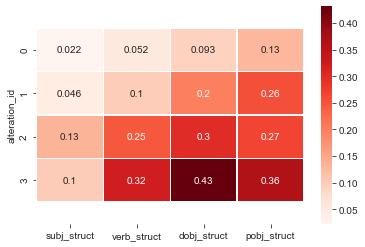

In [65]:

show_df_hm2(var_wise_scores.drop(['syntemp', 'lextemp'], axis=1))


In [6]:
def get_encoder_disentanglement_score(data_iter):
    rel_idx, att_maxes = [], []
    for i, batch in enumerate(tqdm(data_iter, desc="Getting model relationship accuracy")):
        rel_idx_i, att_maxes_i = get_att_and_rel_idx(batch.text[..., 1:])
        rel_idx.extend(rel_idx_i)
        att_maxes.extend(att_maxes_i)
        
    lv_scores = []
    for lv in range(sum(h_params.n_latents)):
        found = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
        for att, rel_pos in zip(att_maxes, rel_idx):
            for k in found.keys():
                if len(rel_pos[k]):
                    found[k].append(att[lv] in rel_pos[k])
        lv_scores.append(found)
    enc_att_scores = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
    for lv in range(sum(h_params.n_latents)):
        for k, v in lv_scores[lv].items():
            enc_att_scores[k].append(np.mean(v))
    print("==== Final Model Scores =======")
    enc_max_score, enc_disent_score, enc_disent_vars = {}, {}, {}
    for k, v in enc_att_scores.items():
        sort_idx = np.argsort(v) 
        enc_disent_vars[k], enc_disent_score[k], enc_max_score[k] =\
            sort_idx[-1], v[sort_idx[-1]] - v[sort_idx[-2]], v[sort_idx[-1]]
    print(enc_max_score)
    print(enc_disent_score)
    print(enc_disent_vars)
    return enc_att_scores, enc_max_score, enc_disent_score, enc_disent_vars
    # # ================= BASELINE ================= 
    # baseline = []
    # for k in ['subj', 'verb', 'dobj', 'pobj']:
    #     all_pos = []
    #     for pos in rel_idx:
    #         all_pos.extend(pos[k])
    #     baseline.append(np.median(all_pos))
    # baseline_scores = []
    # for lv in range(4):
    #     found = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
    #     for rel_pos in rel_idx:
    #         for k in found.keys():
    #             if len(rel_pos[k]):
    #                 found[k].append(baseline[lv] in rel_pos[k])
    #     baseline_scores.append(found)
    # 
    # baseline_enc_att_scores = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
    # for lv in range(sum(h_params.n_latents)):
    #     for k, v in baseline_scores[lv].items():
    #         baseline_enc_att_scores[k].append(np.mean(v))
    # print("==== Final baseline Scores =======")
    # enc_max_score, enc_disent_score, enc_disent_vars = {}, {}, {}
    # for k, v in baseline_enc_att_scores.items():
    #     sort_idx = np.argsort(v) 
    #     enc_disent_vars[k], enc_disent_score[k], enc_max_score[k] =\
    #         sort_idx[-1], v[sort_idx[-1]] - v[sort_idx[-2]], v[sort_idx[-1]]
    # print(enc_max_score)
    # print(enc_disent_score)
    # print(enc_disent_vars)

def show_df_hm2(df):
    snsplt = sns.heatmap(df, cmap ='Reds', linewidths = 0.20, annot = False)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    return snsplt.get_figure()
enc_att, enc_max, enc_disent, enc_disent_idx = \
    get_encoder_disentanglement_score(data.val_iter)
data.reinit_iterator('valid')

Getting model relationship accuracy:   0%|          | 0/417 [00:00<?, ?it/s]

Getting model relationship accuracy:   1%|          | 3/417 [00:00<00:17, 23.69it/s]

Getting model relationship accuracy:   1%|▏         | 6/417 [00:00<00:16, 24.67it/s]

Getting model relationship accuracy:   2%|▏         | 9/417 [00:00<00:16, 24.49it/s]

Getting model relationship accuracy:   3%|▎         | 12/417 [00:00<00:16, 24.78it/s]

Getting model relationship accuracy:   3%|▎         | 14/417 [00:00<00:18, 22.00it/s]

Getting model relationship accuracy:   4%|▍         | 17/417 [00:00<00:17, 22.84it/s]

Getting model relationship accuracy:   5%|▍         | 20/417 [00:00<00:16, 23.36it/s]

Getting model relationship accuracy:   6%|▌         | 23/417 [00:00<00:16, 23.67it/s]

Getting model relationship accuracy:   6%|▌         | 26/417 [00:01<00:16, 23.35it/s]

Getting model relationship accuracy:   7%|▋         | 29/417 [00:01<00:16, 23.89it/s]

Getting model relationship accuracy:   8%|▊         | 32/417 [00:01<00:15, 24.12it/s]

Getting model relationship accuracy:   8%|▊         | 35/417 [00:01<00:15, 24.57it/s]

Getting model relationship accuracy:   9%|▉         | 38/417 [00:01<00:15, 24.30it/s]

Getting model relationship accuracy:  10%|▉         | 41/417 [00:01<00:16, 23.27it/s]

Getting model relationship accuracy:  11%|█         | 44/417 [00:01<00:16, 23.07it/s]

Getting model relationship accuracy:  11%|█▏        | 47/417 [00:01<00:15, 23.47it/s]

Getting model relationship accuracy:  12%|█▏        | 50/417 [00:02<00:15, 24.04it/s]

Getting model relationship accuracy:  13%|█▎        | 53/417 [00:02<00:15, 24.05it/s]

Getting model relationship accuracy:  13%|█▎        | 56/417 [00:02<00:14, 24.29it/s]

Getting model relationship accuracy:  14%|█▍        | 59/417 [00:02<00:14, 24.28it/s]

Getting model relationship accuracy:  15%|█▍        | 62/417 [00:02<00:15, 23.64it/s]

Getting model relationship accuracy:  16%|█▌        | 65/417 [00:02<00:14, 24.05it/s]

Getting model relationship accuracy:  16%|█▋        | 68/417 [00:02<00:14, 23.33it/s]

Getting model relationship accuracy:  17%|█▋        | 71/417 [00:02<00:15, 23.00it/s]

Getting model relationship accuracy:  18%|█▊        | 74/417 [00:03<00:15, 21.70it/s]

Getting model relationship accuracy:  18%|█▊        | 77/417 [00:03<00:16, 21.09it/s]

Getting model relationship accuracy:  19%|█▉        | 80/417 [00:03<00:15, 21.30it/s]

Getting model relationship accuracy:  20%|█▉        | 83/417 [00:03<00:15, 21.63it/s]

Getting model relationship accuracy:  21%|██        | 86/417 [00:03<00:14, 22.21it/s]

Getting model relationship accuracy:  21%|██▏       | 89/417 [00:03<00:15, 21.84it/s]

Getting model relationship accuracy:  22%|██▏       | 92/417 [00:03<00:14, 22.36it/s]

Getting model relationship accuracy:  23%|██▎       | 95/417 [00:04<00:14, 22.80it/s]

Getting model relationship accuracy:  24%|██▎       | 98/417 [00:04<00:14, 22.24it/s]

Getting model relationship accuracy:  24%|██▍       | 101/417 [00:04<00:14, 22.50it/s]

Getting model relationship accuracy:  25%|██▍       | 104/417 [00:04<00:13, 23.21it/s]

Getting model relationship accuracy:  26%|██▌       | 107/417 [00:04<00:12, 23.85it/s]

Getting model relationship accuracy:  26%|██▋       | 110/417 [00:04<00:12, 24.68it/s]

Getting model relationship accuracy:  27%|██▋       | 113/417 [00:04<00:12, 25.17it/s]

Getting model relationship accuracy:  28%|██▊       | 116/417 [00:04<00:11, 25.46it/s]

Getting model relationship accuracy:  29%|██▊       | 119/417 [00:05<00:11, 25.53it/s]

Getting model relationship accuracy:  29%|██▉       | 122/417 [00:05<00:11, 25.20it/s]

Getting model relationship accuracy:  30%|██▉       | 125/417 [00:05<00:11, 25.03it/s]

Getting model relationship accuracy:  31%|███       | 128/417 [00:05<00:11, 25.30it/s]

Getting model relationship accuracy:  31%|███▏      | 131/417 [00:05<00:11, 25.10it/s]

Getting model relationship accuracy:  32%|███▏      | 134/417 [00:05<00:10, 25.73it/s]

Getting model relationship accuracy:  33%|███▎      | 137/417 [00:05<00:10, 26.27it/s]

Getting model relationship accuracy:  34%|███▎      | 140/417 [00:05<00:10, 26.30it/s]

Getting model relationship accuracy:  34%|███▍      | 143/417 [00:05<00:10, 26.33it/s]

Getting model relationship accuracy:  35%|███▌      | 146/417 [00:06<00:10, 26.70it/s]

Getting model relationship accuracy:  36%|███▌      | 149/417 [00:06<00:09, 26.89it/s]

Getting model relationship accuracy:  36%|███▋      | 152/417 [00:06<00:09, 26.81it/s]

Getting model relationship accuracy:  37%|███▋      | 155/417 [00:06<00:09, 27.19it/s]

Getting model relationship accuracy:  38%|███▊      | 158/417 [00:06<00:09, 27.46it/s]

Getting model relationship accuracy:  39%|███▊      | 161/417 [00:06<00:09, 27.42it/s]

Getting model relationship accuracy:  39%|███▉      | 164/417 [00:06<00:09, 27.63it/s]

Getting model relationship accuracy:  40%|████      | 167/417 [00:06<00:09, 27.54it/s]

Getting model relationship accuracy:  41%|████      | 170/417 [00:06<00:09, 27.18it/s]

Getting model relationship accuracy:  41%|████▏     | 173/417 [00:07<00:08, 27.23it/s]

Getting model relationship accuracy:  42%|████▏     | 176/417 [00:07<00:08, 27.27it/s]

Getting model relationship accuracy:  43%|████▎     | 179/417 [00:07<00:08, 27.44it/s]

Getting model relationship accuracy:  44%|████▎     | 182/417 [00:07<00:08, 27.71it/s]

Getting model relationship accuracy:  44%|████▍     | 185/417 [00:07<00:08, 27.99it/s]

Getting model relationship accuracy:  45%|████▌     | 188/417 [00:07<00:08, 28.18it/s]

Getting model relationship accuracy:  46%|████▌     | 191/417 [00:07<00:08, 27.93it/s]

Getting model relationship accuracy:  47%|████▋     | 194/417 [00:07<00:08, 27.52it/s]

Getting model relationship accuracy:  47%|████▋     | 197/417 [00:07<00:07, 27.70it/s]

Getting model relationship accuracy:  48%|████▊     | 200/417 [00:08<00:07, 27.82it/s]

Getting model relationship accuracy:  49%|████▊     | 203/417 [00:08<00:07, 27.91it/s]

Getting model relationship accuracy:  49%|████▉     | 206/417 [00:08<00:07, 28.05it/s]

Getting model relationship accuracy:  50%|█████     | 209/417 [00:08<00:07, 28.07it/s]

Getting model relationship accuracy:  51%|█████     | 212/417 [00:08<00:07, 28.00it/s]

Getting model relationship accuracy:  52%|█████▏    | 215/417 [00:08<00:07, 27.65it/s]

Getting model relationship accuracy:  52%|█████▏    | 218/417 [00:08<00:07, 27.63it/s]

Getting model relationship accuracy:  53%|█████▎    | 221/417 [00:08<00:07, 27.17it/s]

Getting model relationship accuracy:  54%|█████▎    | 224/417 [00:08<00:07, 27.45it/s]

Getting model relationship accuracy:  54%|█████▍    | 227/417 [00:09<00:06, 27.80it/s]

Getting model relationship accuracy:  55%|█████▌    | 230/417 [00:09<00:06, 27.81it/s]

Getting model relationship accuracy:  56%|█████▌    | 233/417 [00:09<00:06, 28.04it/s]

Getting model relationship accuracy:  57%|█████▋    | 236/417 [00:09<00:06, 27.83it/s]

Getting model relationship accuracy:  57%|█████▋    | 239/417 [00:09<00:06, 27.91it/s]

Getting model relationship accuracy:  58%|█████▊    | 242/417 [00:09<00:06, 28.13it/s]

Getting model relationship accuracy:  59%|█████▉    | 245/417 [00:09<00:06, 28.04it/s]

Getting model relationship accuracy:  59%|█████▉    | 248/417 [00:09<00:05, 28.22it/s]

Getting model relationship accuracy:  60%|██████    | 251/417 [00:09<00:05, 28.02it/s]

Getting model relationship accuracy:  61%|██████    | 254/417 [00:09<00:05, 28.05it/s]

Getting model relationship accuracy:  62%|██████▏   | 257/417 [00:10<00:05, 27.84it/s]

Getting model relationship accuracy:  62%|██████▏   | 260/417 [00:10<00:05, 27.76it/s]

Getting model relationship accuracy:  63%|██████▎   | 263/417 [00:10<00:05, 27.95it/s]

Getting model relationship accuracy:  64%|██████▍   | 266/417 [00:10<00:05, 27.84it/s]

Getting model relationship accuracy:  65%|██████▍   | 269/417 [00:10<00:05, 28.08it/s]

Getting model relationship accuracy:  65%|██████▌   | 272/417 [00:10<00:05, 27.93it/s]

Getting model relationship accuracy:  66%|██████▌   | 275/417 [00:10<00:05, 28.07it/s]

Getting model relationship accuracy:  67%|██████▋   | 278/417 [00:10<00:04, 28.24it/s]

Getting model relationship accuracy:  67%|██████▋   | 281/417 [00:10<00:04, 27.96it/s]

Getting model relationship accuracy:  68%|██████▊   | 284/417 [00:11<00:04, 27.93it/s]

Getting model relationship accuracy:  69%|██████▉   | 287/417 [00:11<00:04, 27.91it/s]

Getting model relationship accuracy:  70%|██████▉   | 290/417 [00:11<00:04, 27.97it/s]

Getting model relationship accuracy:  70%|███████   | 293/417 [00:11<00:04, 27.46it/s]

Getting model relationship accuracy:  71%|███████   | 296/417 [00:11<00:04, 26.98it/s]

Getting model relationship accuracy:  72%|███████▏  | 299/417 [00:11<00:04, 26.73it/s]

Getting model relationship accuracy:  72%|███████▏  | 302/417 [00:11<00:04, 26.98it/s]

Getting model relationship accuracy:  73%|███████▎  | 305/417 [00:11<00:04, 27.46it/s]

Getting model relationship accuracy:  74%|███████▍  | 308/417 [00:11<00:03, 27.43it/s]

Getting model relationship accuracy:  75%|███████▍  | 311/417 [00:12<00:03, 27.33it/s]

Getting model relationship accuracy:  75%|███████▌  | 314/417 [00:12<00:03, 27.18it/s]

Getting model relationship accuracy:  76%|███████▌  | 317/417 [00:12<00:03, 27.23it/s]

Getting model relationship accuracy:  77%|███████▋  | 320/417 [00:12<00:03, 27.34it/s]

Getting model relationship accuracy:  77%|███████▋  | 323/417 [00:12<00:03, 27.57it/s]

Getting model relationship accuracy:  78%|███████▊  | 326/417 [00:12<00:03, 27.73it/s]

Getting model relationship accuracy:  79%|███████▉  | 329/417 [00:12<00:03, 27.84it/s]

Getting model relationship accuracy:  80%|███████▉  | 332/417 [00:12<00:03, 27.92it/s]

Getting model relationship accuracy:  80%|████████  | 335/417 [00:12<00:02, 27.90it/s]

Getting model relationship accuracy:  81%|████████  | 338/417 [00:13<00:02, 27.81it/s]

Getting model relationship accuracy:  82%|████████▏ | 341/417 [00:13<00:02, 27.67it/s]

Getting model relationship accuracy:  82%|████████▏ | 344/417 [00:13<00:02, 27.65it/s]

Getting model relationship accuracy:  83%|████████▎ | 347/417 [00:13<00:02, 27.79it/s]

Getting model relationship accuracy:  84%|████████▍ | 350/417 [00:13<00:02, 27.88it/s]

Getting model relationship accuracy:  85%|████████▍ | 353/417 [00:13<00:02, 26.83it/s]

Getting model relationship accuracy:  85%|████████▌ | 356/417 [00:13<00:02, 27.13it/s]

Getting model relationship accuracy:  86%|████████▌ | 359/417 [00:13<00:02, 27.16it/s]

Getting model relationship accuracy:  87%|████████▋ | 362/417 [00:13<00:02, 27.36it/s]

Getting model relationship accuracy:  88%|████████▊ | 365/417 [00:14<00:01, 27.43it/s]

Getting model relationship accuracy:  88%|████████▊ | 368/417 [00:14<00:01, 27.40it/s]

Getting model relationship accuracy:  89%|████████▉ | 371/417 [00:14<00:01, 27.62it/s]

Getting model relationship accuracy:  90%|████████▉ | 374/417 [00:14<00:01, 26.44it/s]

Getting model relationship accuracy:  90%|█████████ | 377/417 [00:14<00:01, 26.78it/s]

Getting model relationship accuracy:  91%|█████████ | 380/417 [00:14<00:01, 27.02it/s]

Getting model relationship accuracy:  92%|█████████▏| 383/417 [00:14<00:01, 26.76it/s]

Getting model relationship accuracy:  93%|█████████▎| 386/417 [00:14<00:01, 26.72it/s]

Getting model relationship accuracy:  93%|█████████▎| 389/417 [00:14<00:01, 26.27it/s]

Getting model relationship accuracy:  94%|█████████▍| 392/417 [00:15<00:00, 26.51it/s]

Getting model relationship accuracy:  95%|█████████▍| 395/417 [00:15<00:00, 26.83it/s]

Getting model relationship accuracy:  95%|█████████▌| 398/417 [00:15<00:00, 26.84it/s]

Getting model relationship accuracy:  96%|█████████▌| 401/417 [00:15<00:00, 27.13it/s]

Getting model relationship accuracy:  97%|█████████▋| 404/417 [00:15<00:00, 26.90it/s]

Getting model relationship accuracy:  98%|█████████▊| 407/417 [00:15<00:00, 27.26it/s]

Getting model relationship accuracy:  98%|█████████▊| 410/417 [00:15<00:00, 27.58it/s]

Getting model relationship accuracy:  99%|█████████▉| 413/417 [00:15<00:00, 27.21it/s]

Getting model relationship accuracy: 100%|█████████▉| 416/417 [00:15<00:00, 27.55it/s]

Getting model relationship accuracy: 100%|██████████| 417/417 [00:15<00:00, 26.18it/s]

==== Final Model Scores =======
{'subj': 0.8359802134860713, 'verb': 0.32040775534679194, 'dobj': 0.4634146341463415, 'pobj': 0.5984567901234568}
{'subj': 0.6894038010934652, 'verb': 0.18149110533679794, 'dobj': 0.11022514071294559, 'pobj': 0.3253086419753086}
{'subj': 2, 'verb': 1, 'dobj': 0, 'pobj': 0}


       subj      verb      dobj      pobj
0  0.036709  0.058165  0.463415  0.598457
1  0.146576  0.320408  0.353189  0.244753
2  0.835980  0.138917  0.000938  0.001852
3  0.004686  0.004997  0.182458  0.273148


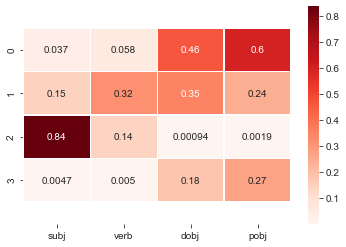

In [7]:

def show_df_hm2(df):
    snsplt = sns.heatmap(df, cmap ='Reds', linewidths = 0.20, annot = True)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    return snsplt.get_figure()
att_df = pd.DataFrame(enc_att)
print(att_df)
sns_plot = show_df_hm2(att_df)
sns_plot.savefig("enc_att.eps", dpi=100, format='eps')

In [11]:

# for i, batch in enumerate(data.val_iter):
#     text_sents = [' '.join([model.index[model.generated_v].itos[w] 
#                             for w in s]).replace(' <pad>', '').replace(' <eos>', '')
#                   for s in batch.text[:, 1:]]
#     # Getting relations' positions
#     rel_idx = shallow_dependencies(text_sents)
#     for r, t in zip(rel_idx, text_sents):
#         # if r['idx']['verb'][0] > 10:
#         print(r, t)
#     if i>10: break
lv_scores = []
for lv in range(sum(h_params.n_latents)):
    found = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
    for att, rel_pos in zip(att_maxes, rel_idx):
        for k in found.keys():
            if len(rel_pos[k]):
                found[k].append(att[lv] in rel_pos[k])
    lv_scores.append(found)

baseline = []
for k in ['subj', 'verb', 'dobj', 'pobj']:
    all_pos = []
    for pos in rel_idx:
        all_pos.extend(pos[k])
    baseline.append(np.median(all_pos))
print(baseline)

baseline_scores = []
for lv in range(4):
    found = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
    for rel_pos in rel_idx:
        for k in found.keys():
            if len(rel_pos[k]):
                found[k].append(baseline[lv] in rel_pos[k])
    baseline_scores.append(found)
            

# found = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
# for att, rel_pos in zip(att_maxes, rel_idx):
#     for k in found.keys():
#         if len(rel_pos[k]):
#             found[k].append(att[lv][layer] in rel_pos[k])


[1.0, 2.0, 5.0, 7.0]


In [14]:
print("========our Model ========")
Enc_att_scores = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
for lv in range(sum(h_params.n_latents)):
    for layer in range(1):#h_params.encoder_l):
        print("Scores for lv {}, layer {}:".format(lv, layer))
        print({k:np.mean(v)for k, v in lv_scores[lv].items()})
        for k, v in lv_scores[lv].items():
            Enc_att_scores[k].append(np.mean(v))
print("==== Final Scores =======")
enc_max_score = {}
enc_disent_score = {}
enc_disent_vars = {}
for k, v in Enc_att_scores.items():
    sort_idx = np.argsort(v) 
    enc_disent_vars[k] = sort_idx[-1]
    enc_disent_score[k] = v[sort_idx[-1]] - v[sort_idx[-2]]
    enc_max_score[k] = v[sort_idx[-1]]
print(enc_max_score)
print(enc_disent_score)
print(enc_disent_vars)
print("========our baseline ========")

baseline_enc_att_scores = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
for lv in range(len(baseline_scores)):
    for layer in range(1):#h_params.encoder_l):
        print("Scores for lv {}, layer {}:".format(lv, layer))
        print({k:np.mean(v)for k, v in baseline_scores[lv].items()})
        for k, v in baseline_scores[lv].items():
            baseline_enc_att_scores[k].append(np.mean(v))
print("==== Final Scores =======")
enc_max_score = {}
enc_disent_score = {}
enc_disent_vars = {}
for k, v in baseline_enc_att_scores.items():
    sort_idx = np.argsort(v) 
    enc_disent_vars[k] = sort_idx[-1]
    enc_disent_score[k] = v[sort_idx[-1]] - v[sort_idx[-2]]
    enc_max_score[k] = v[sort_idx[-1]]
print(enc_max_score)
print(enc_disent_score, sum(enc_disent_score.values()))
print(enc_disent_vars)

========our Model ========
Scores for lv 0, layer 0:
{'subj': 0.38920863309352516, 'verb': 0.27425, 'dobj': 0.10831426392067124, 'pobj': 0.061317183951551855}
Scores for lv 1, layer 0:
{'subj': 0.11726618705035971, 'verb': 0.12575, 'dobj': 0.38367658276125094, 'pobj': 0.23164269492808479}
Scores for lv 2, layer 0:
{'subj': 0.0, 'verb': 0.0, 'dobj': 0.006864988558352402, 'pobj': 0.008327024981074944}
Scores for lv 3, layer 0:
{'subj': 0.05, 'verb': 0.0335, 'dobj': 0.3531655225019069, 'pobj': 0.36260408781226344}
Scores for lv 4, layer 0:
{'subj': 0.002158273381294964, 'verb': 0.00375, 'dobj': 0.10907704042715484, 'pobj': 0.16654049962149886}
Scores for lv 5, layer 0:
{'subj': 0.02194244604316547, 'verb': 0.03, 'dobj': 0.2387490465293669, 'pobj': 0.33459500378501134}
Scores for lv 6, layer 0:
{'subj': 0.007553956834532374, 'verb': 0.0145, 'dobj': 0.18916857360793288, 'pobj': 0.24072672218016655}
Scores for lv 7, layer 0:
{'subj': 0.7607913669064749, 'verb': 0.09475, 'dobj': 0.00457665903

In [1]:
import spacy
nlp = spacy.load("en_core_web_sm")


In [18]:
ex_sents = ["i 'll never be going back", "great food, great service",
            "decoration is outdated .",
            "the guy in front of us was ordering in spanish .",
            "worst service ever .", "the worst experience i have ever had at an enterprise location .",
            'waitresses are slow', "this place is awful !"]
import itertools
def get_children(tok, depth):
    if depth == 0:
        return list(tok.children)
    else:
        return list(tok.children) + \
               list(itertools.chain.from_iterable([get_children(c, depth-1) for c in tok.children]))

def truncated_template(sents, depth):
    docs = nlp.pipe(sents)
    templates = []
    for doc in docs:
        children = None
        for i, tok in enumerate(doc):
            if tok.dep_ =='ROOT':
                children = [tok]+get_children(tok, depth)
        if children is not None:
            sort_dict_lex = {c.i:c.text for c in children}
            sort_dict_syn = {c.i:c.dep_ for c in children}
            templates.append({'lex': ' '.join([sort_dict_lex[i] for i in sorted(sort_dict_lex.keys())]),
                              'syn': ' '.join([sort_dict_syn[i] for i in sorted(sort_dict_syn.keys())])})
        else: 
            raise NotImplementedError("This sentence has no ROOT: ".format(' '.join([t.text for t in doc])))

    
docs = nlp.pipe(ex_sents)
for doc in docs:
    print(doc.text)
    print(truncated_template(doc, 0))


i 'll never be going back
("i 'll never be going back", 'nsubj aux neg aux ROOT advmod')
great food, great service
('great food , service', 'amod ROOT punct appos')
decoration is outdated .
('decoration is outdated .', 'nsubjpass auxpass ROOT punct')
the guy in front of us was ordering in spanish .
('guy was ordering in .', 'nsubj aux ROOT prep punct')
worst service ever .
('worst service ever .', 'amod ROOT advmod punct')
the worst experience i have ever had at an enterprise location .
('the worst experience had .', 'det amod ROOT relcl punct')
waitresses are slow
('waitresses are slow', 'nsubj ROOT acomp')
this place is awful !
('place is awful !', 'nsubj ROOT acomp punct')


In [5]:
import pandas as pd
from tqdm import tqdm
      
import spacy
from disentanglement_transformer.models import shallow_dependencies, truncated_template
nlp = spacy.load("en_core_web_sm")

ex_sents = ['i was originally told it would take _num_ mins .',
            'slow , over priced , i \'ll go elsewhere next time .',
            'we will not be back',
            'terrible .',
            'at this point they were open and would be for another hour .',
            'people are outside playing baseball .',
            'two dogs pull on opposite ends of a rope .',
            'a lady lays at a beach .',
            'the construction workers are using a pick axes to poke each other .',
            'people are running through the streets while people watch .',
            'someone prepares food into bowls ']
orig = ['Yelp']*5+['SNLI']*5
print([(tok.text, tok.dep_) for tok in nlp(
            'the construction workers are using a pick axes to poke each other .')])


roles, temptypes = ['subj', 'verb', 'dobj', 'pobj'], ['syn', 'lex']
deps = shallow_dependencies(ex_sents)
temps = truncated_template(ex_sents)
print(deps)
for i in range(len(ex_sents)):
    print(orig[i], '& ',ex_sents[i], '& ', '& '.join([deps[i]['text'][k] for k in roles]), '& ',
          '& '.join([temps[i][k] for k in temptypes]), '\\\\ \hline')

[('the', 'det'), ('construction', 'compound'), ('workers', 'nsubj'), ('are', 'aux'), ('using', 'ROOT'), ('a', 'det'), ('pick', 'amod'), ('axes', 'dobj'), ('to', 'aux'), ('poke', 'xcomp'), ('each', 'det'), ('other', 'dobj'), ('.', 'punct')]
[{'text': {'subj': 'it', 'verb': 'told', 'dobj': '_ num _ mins', 'pobj': ''}, 'idx': {'subj': [4], 'verb': [3], 'dobj': [7, 8, 9, 10], 'pobj': []}}, {'text': {'subj': 'i', 'verb': 'go', 'dobj': '', 'pobj': ''}, 'idx': {'subj': [5], 'verb': [7], 'dobj': [], 'pobj': []}}, {'text': {'subj': 'we', 'verb': '', 'dobj': '', 'pobj': ''}, 'idx': {'subj': [0], 'verb': [], 'dobj': [], 'pobj': []}}, {'text': {'subj': '', 'verb': '', 'dobj': '', 'pobj': ''}, 'idx': {'subj': [], 'verb': [], 'dobj': [], 'pobj': []}}, {'text': {'subj': 'they', 'verb': '', 'dobj': '', 'pobj': 'this point'}, 'idx': {'subj': [3], 'verb': [], 'dobj': [], 'pobj': [1, 2]}}, {'text': {'subj': 'people', 'verb': '', 'dobj': 'baseball', 'pobj': ''}, 'idx': {'subj': [0], 'verb': [], 'dobj': [4

IndexError: list index out of range

In [2]:
text, samples, params = model.get_sentences(5, gen_len=16, sample_w=False, vary_z=True, complete=None, contains=None, max_tries=100)

print(text)


[' a man is sitting on a gate at a lot of a blanket ', ' a group of men are eating a meal ', ' the people are sitting on a board ', ' a man is playing a guitar ', ' a couple being chased by a game in the park ']


In [46]:
from tqdm import tqdm
      
import spacy
from benepar.spacy_plugin import BeneparComponent

# nlp = spacy.load("en_core_web_sm")
# try:   
#     nlp.add_pipe(BeneparComponent('benepar_en3'))
# except LookupError:
#     import benepar
#     benepar.download('benepar_en3')
#     nlp.add_pipe(BeneparComponent('benepar_en3'))
    

def truncate_tree(tree, lv):
    tok_i = 0
    curr_lv = 0
    tree_toks = tree.split()
    while tok_i != len(tree_toks):
        if tree_toks[tok_i].startswith('('):
            curr_lv += 1
        else:
            closed_lvs = int(tree_toks[tok_i].count(')'))
            if curr_lv - closed_lvs <= lv:
                tree_toks[tok_i] = ')'*(closed_lvs - (curr_lv-lv))
            curr_lv -= closed_lvs
        if lv >= curr_lv and tree_toks[tok_i]!='':
            tok_i += 1
        else:
            tree_toks.pop(tok_i)
    return ' '.join(tree_toks)


def template_match(l1, l2, lv, verbose=0):
    docs1, docs2 = nlp.pipe(l1), nlp.pipe(l2)
    temps1 = [truncate_tree(list(doc.sents)[0]._.parse_string, lv) for doc in docs1]
    temps2 = [truncate_tree(list(doc.sents)[0]._.parse_string, lv) for doc in docs2]
    if verbose:
        for l, t in zip(l1+l2, temps1+temps2):
            print(l, "-->", t)
        print("+++++++++++++++++++++++++")
    return [t1 == t2 for t1, t2 in zip(temps1, temps2)]

ex_sents = ['i traded cards',
            'i was originally told it would take _num_ mins .',
            'slow , over priced , i \'ll go elsewhere next time .',
            'we will not be back',
            'terrible .',
            'at this point they were open and would be for another hour .',
            'people are outside playing baseball .',
            'two dogs pull on opposite ends of a rope .',
            'a lady lays at a beach .',
            'the construction workers are using a pick axes to poke each other .',
            'people are running through the streets while people watch .',
            'someone prepares food into bowls ']
# docs = nlp.pipe(ex_sents)
# for i, doc in enumerate(docs):
#     print("-------------------------------")
#     print("sentence-->", ex_sents[i])
#     parse = list(doc.sents)[0]._.parse_string
#     print("parse-->", parse)
#     print("truncated parse-->", truncate_tree(parse, 3))



my_sents1 = ['i go to the market',
            'while i come back, it should be done.']
my_sents2 = ['she uses the toilet',
            'once i treat my wounds, i will go back to battle.']
for this_lv in [2, 3]:
    matches = template_match(my_sents1, my_sents2, this_lv, verbose=1)
    for i in range(len(my_sents1)):
        print("These sentences", "" if matches[i] else "DON'T", " match at level {}:\n".format(this_lv),
              my_sents1[i], '|||||', my_sents2[i])
    print("==================")
 

i go to the market --> (S (NP ) (VP ))
while i come back, it should be done. --> (S (SBAR ) (, ) (NP ) (VP ) (. ))
she uses the toilet --> (S (NP ) (VP ))
once i treat my wounds, i will go back to battle. --> (S (SBAR ) (, ) (NP ) (VP ) (. ))
+++++++++++++++++++++++++
These sentences   match at level 2:
 i go to the market ||||| she uses the toilet
These sentences   match at level 2:
 while i come back, it should be done. ||||| once i treat my wounds, i will go back to battle.
i go to the market --> (S (NP (PRP )) (VP (VBP ) (PP )))
while i come back, it should be done. --> (S (SBAR (IN ) (S )) (, )) (NP (PRP )) (VP (MD ) (VP )) (. )))
she uses the toilet --> (S (NP (PRP )) (VP (VBZ ) (NP )))
once i treat my wounds, i will go back to battle. --> (S (SBAR (IN ) (S )) (, )) (NP (PRP )) (VP (MD ) (VP )) (. )))
+++++++++++++++++++++++++
These sentences DON'T  match at level 3:
 i go to the market ||||| she uses the toilet
These sentences   match at level 3:
 while i come back, it should be

In [14]:
from tqdm import tqdm
# subject:2, verb:3, obj/pobj:1
var_ids = [1]
alt_text, alt_params = model._get_alternative_sentences(samples, None, var_ids, 4, 16, complete=None)
for i in range(len(text)):
    print(text[i], ':', alt_text[i::len(text)])
with open('dump.csv', 'w') as f:
    for r_n, r_id in {"subject":2, "verb":3, "pobj/dobj":1}.items():
        for i in tqdm(range(20)):
            text, samples, params = model.get_sentences(25, gen_len=16, sample_w=False, vary_z=True, complete=None, contains=None, max_tries=100)
            alt_text, alt_params = model._get_alternative_sentences(samples, None, [r_id], 5, 16, complete=None)
            for j in range(len(text)):
                f.write('|'.join(["resampled "+r_n, text[j]]+alt_text[j::len(text)])+'\n')
    


  0%|          | 0/20 [00:00<?, ?it/s]

 a girl is playing with a ball  : [' a girl is playing with a ball ', ' a girl is playing with a ball ', ' a girl is playing with a ball ', ' a woman is playing with a dog ']
 a young man playing the top of a bubble  : [' a young man playing his guitar ', ' a young man and his dog are playing fetch with a bubble ', ' a young man and his wares look at a bubble ', ' a young man playing his guitar ']
 two teams are working  : [' two teams are working ', ' two teams are working ', ' two teams are working on the rodeo on the roller coaster ', ' two teams are working in a water kitchen ']
 a dog is sitting at a table  : [' a dog is sitting at a table ', ' a man in red and blue shirt is wearing a red shirt ', ' a man in red and sunglasses is watching a game ', ' a boy in red and plaid shirt stands in a field ']
 a man is on a bike  : [' a man is on a bike ', ' a man is on a bike ', ' a man is on a bike ', ' a man is on a bike ']
 two men are riding a bike  : [' two men are riding a empty stre

  5%|▌         | 1/20 [00:00<00:11,  1.59it/s]

 10%|█         | 2/20 [00:01<00:11,  1.61it/s]

 15%|█▌        | 3/20 [00:02<00:12,  1.38it/s]

 20%|██        | 4/20 [00:02<00:11,  1.41it/s]

 25%|██▌       | 5/20 [00:03<00:10,  1.43it/s]

 30%|███       | 6/20 [00:04<00:09,  1.48it/s]

 35%|███▌      | 7/20 [00:04<00:08,  1.51it/s]

 40%|████      | 8/20 [00:05<00:07,  1.55it/s]

 45%|████▌     | 9/20 [00:05<00:06,  1.62it/s]

 50%|█████     | 10/20 [00:06<00:05,  1.68it/s]

 55%|█████▌    | 11/20 [00:07<00:05,  1.73it/s]

 60%|██████    | 12/20 [00:07<00:04,  1.74it/s]

 65%|██████▌   | 13/20 [00:08<00:03,  1.75it/s]

 70%|███████   | 14/20 [00:08<00:03,  1.80it/s]

 75%|███████▌  | 15/20 [00:09<00:02,  1.83it/s]

 80%|████████  | 16/20 [00:09<00:02,  1.83it/s]

 85%|████████▌ | 17/20 [00:10<00:01,  1.84it/s]

 90%|█████████ | 18/20 [00:10<00:01,  1.85it/s]

 95%|█████████▌| 19/20 [00:11<00:00,  1.86it/s]

100%|██████████| 20/20 [00:11<00:00,  1.86it/s]

100%|██████████| 20/20 [00:11<00:00,  1.68it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:00<00:10,  1.87it/s]

 10%|█         | 2/20 [00:01<00:09,  1.86it/s]

 15%|█▌        | 3/20 [00:01<00:09,  1.86it/s]

 20%|██        | 4/20 [00:02<00:08,  1.87it/s]

 25%|██▌       | 5/20 [00:02<00:08,  1.85it/s]

 30%|███       | 6/20 [00:03<00:07,  1.87it/s]

 35%|███▌      | 7/20 [00:03<00:07,  1.86it/s]

 40%|████      | 8/20 [00:04<00:06,  1.85it/s]

 45%|████▌     | 9/20 [00:04<00:05,  1.85it/s]

 50%|█████     | 10/20 [00:05<00:05,  1.86it/s]

 55%|█████▌    | 11/20 [00:05<00:04,  1.86it/s]

 60%|██████    | 12/20 [00:06<00:04,  1.85it/s]

 65%|██████▌   | 13/20 [00:07<00:03,  1.84it/s]

 70%|███████   | 14/20 [00:07<00:03,  1.85it/s]

 75%|███████▌  | 15/20 [00:08<00:02,  1.83it/s]

 80%|████████  | 16/20 [00:08<00:02,  1.83it/s]

 85%|████████▌ | 17/20 [00:09<00:01,  1.83it/s]

 90%|█████████ | 18/20 [00:09<00:01,  1.82it/s]

 95%|█████████▌| 19/20 [00:10<00:00,  1.83it/s]

100%|██████████| 20/20 [00:10<00:00,  1.84it/s]

100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:00<00:10,  1.76it/s]

 10%|█         | 2/20 [00:01<00:10,  1.79it/s]

 15%|█▌        | 3/20 [00:01<00:09,  1.79it/s]

 20%|██        | 4/20 [00:02<00:08,  1.81it/s]

 25%|██▌       | 5/20 [00:02<00:08,  1.81it/s]

 30%|███       | 6/20 [00:03<00:07,  1.83it/s]

 35%|███▌      | 7/20 [00:03<00:07,  1.82it/s]

 40%|████      | 8/20 [00:04<00:06,  1.82it/s]

 45%|████▌     | 9/20 [00:04<00:06,  1.83it/s]

 50%|█████     | 10/20 [00:05<00:05,  1.83it/s]

 55%|█████▌    | 11/20 [00:05<00:04,  1.86it/s]

 60%|██████    | 12/20 [00:06<00:04,  1.85it/s]

 65%|██████▌   | 13/20 [00:07<00:03,  1.86it/s]

 70%|███████   | 14/20 [00:07<00:03,  1.85it/s]

 75%|███████▌  | 15/20 [00:08<00:02,  1.84it/s]

 80%|████████  | 16/20 [00:08<00:02,  1.82it/s]

 85%|████████▌ | 17/20 [00:09<00:01,  1.82it/s]

 90%|█████████ | 18/20 [00:09<00:01,  1.83it/s]

 95%|█████████▌| 19/20 [00:10<00:00,  1.82it/s]

100%|██████████| 20/20 [00:10<00:00,  1.82it/s]

100%|██████████| 20/20 [00:10<00:00,  1.83it/s]

In [7]:
from tqdm import tqdm
# subject:2, verb:3, obj/pobj:1
with open('dump_paper.csv', 'w') as f:
    f.write('Original sentence& Resampled subject& Resampled verb & Resampled dobj/pobj\n')
    for i in tqdm(range(4)):
        text, samples, params = model.get_sentences(25, gen_len=16, 
                                                    sample_w=False, vary_z=True, 
                                                    complete=None, contains=None, 
                                                    max_tries=100)
        alt_text_subj, _ = model._get_alternative_sentences(samples, None, [2], 
                                                                1, 16, complete=None)
        alt_text_verb, _ = model._get_alternative_sentences(samples, None, [3], 
                                                                1, 16, complete=None)
        alt_text_dpobj, _ = model._get_alternative_sentences(samples, None, [1], 
                                                                1, 16, complete=None)
        for j in range(len(text)):
            f.write(' &'.join([text[j], alt_text_subj[j],
                              alt_text_verb[j], alt_text_dpobj[j]])+'\\\\\n')
    


  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.06it/s]

 50%|█████     | 2/4 [00:01<00:01,  1.09it/s]

 75%|███████▌  | 3/4 [00:02<00:00,  1.08it/s]

100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

In [36]:
var_ids = [2]
alt_text, alt_params = model._get_alternative_sentences(samples, None, var_ids, 2, 16, complete=None)
for i in range(len(text)):
    print(text[i], ':', alt_text[i::len(text)])

 no server , he was very friendly and helpful  : [' no server , he had to die for our slice of ed ', ' no server , he gave me , but our slice of sort of soup ']
 the staff is friendly and helpful and friendly  : [' wrong ', " i 've been here twice for dinner "]
 the place is way more than the food is good  : [' the place is way more than the food is good ', ' the place is way more than the food is good ']
 amazing service , what a good time  : [' amazing service , what a great place to eat ', " i 've always enjoyed this location because this place was really positive "]
 i 've been here twice and we 're quite happy with my experience  : [' the staff is friendly and the food is quite easy as well ', ' great food ']


In [29]:
var_ids = [3, 4, 5, 6, 7]
alt_text, alt_params = model._get_alternative_sentences(samples, None, var_ids, 2, 16, complete=None)
for i in range(len(text)):
    print(text[i], ':', alt_text[i::len(text)])

 no server , he was very friendly and helpful  : [' great service and great food ', ' great service ']
 the staff is friendly and helpful and friendly  : [' our food was very good and loved it and it disappeared ', ' the staff is friendly and helpful and so hard to pay her cafe ']
 the place is way more than the food is good  : [' the food was delicious and the service was great ', ' the food was delicious and the service was great ']
 amazing service , what a good time  : [' amazing people ', ' the food is always good , service is great ']
 i 've been here twice and we 're quite happy with my experience  : [' the food is always fresh and delicious ', ' i will definitely be back again ']


In [37]:
def decode_to_text(x_hat_params, vocab_size, vocab_index):
    # It is assumed that this function is used at test time for display purposes
    # Getting the argmax from the one hot if it's not done
    while x_hat_params.shape[-1] == vocab_size and x_hat_params.ndim > 3:
        x_hat_params = x_hat_params.mean(0)
    while x_hat_params.ndim > 2 and x_hat_params.shape[-1] != self.h_params.vocab_size:
        x_hat_params = x_hat_params[0]
    if x_hat_params.shape[-1] == vocab_size:
        x_hat_params = torch.argmax(x_hat_params, dim=-1)
    assert x_hat_params.ndim == 2, "Mis-shaped generated sequence: {}".format(x_hat_params.shape)
    
    samples = [' '.join([vocab_index.itos[w]
                         for w in sen]).split('<eos>')[0].split(' !')[0].split(' .')[0].replace('<go>', '').replace('</go>', '')
               .replace('<pad>', '_').replace('_unk', '<?>')
               for sen in x_hat_params]

    return samples


def swap_latents(mdl, prev_latent_vals, var_z_ids, gen_len, complete=None, no_unk=True):
            n_orig_sentences = prev_latent_vals['z1'].shape[0]
            n_samples = n_orig_sentences
            go_symbol = torch.ones([n_samples * n_orig_sentences]).long() * \
                        mdl.index[mdl.generated_v].stoi['<go>']
            go_symbol = go_symbol.to(mdl.h_params.device).unsqueeze(-1)
            x_prev = go_symbol
            if complete is not None:
                for token in complete.split(' '):
                    x_prev = torch.cat([x_prev, torch.ones([n_samples * n_orig_sentences, 1]).long().to(mdl.h_params.device) * \
                        mdl.index[mdl.generated_v].stoi[token]], dim=1)
                gen_len = gen_len - len(complete.split(' '))
            temp = 1.
            orig_z = prev_latent_vals['z1'].unsqueeze(1).repeat(1, n_samples, 1)
            z_sample = orig_z.reshape(n_samples*n_orig_sentences, -1)
            orig_z = orig_z.transpose(0, 1).reshape(n_samples*n_orig_sentences, -1)

            for id in var_z_ids:
                z_number = sum([id> sum(h_params.n_latents[:i+1]) for i in range(len(h_params.n_latents))])
                z_index = id - sum(h_params.n_latents[:z_number])
                start, end = int(h_params.z_size/max(h_params.n_latents)*z_index),\
                             int(h_params.z_size/max(h_params.n_latents)*(z_index+1))
                source, destination = [z_sample][z_number], [orig_z][z_number]
                destination[:, start:end] = source[:, start:end]
            
            z_input = {'z1': orig_z.unsqueeze(1)}
            
            # Normal Autoregressive generation
            for i in range(gen_len):
                mdl.gen_bn({'x_prev': x_prev, **{k: v.expand(v.shape[0], i+1, v.shape[-1])
                                                  for k, v in z_input.items()}})
                samples_i = mdl.generated_v.post_params['logits']
                if no_unk:
                    annul_vector = 1-F.one_hot(torch.tensor([data.vocab.stoi['<unk>']]).to(DEVICE), h_params.vocab_size)
                    samples_i *= annul_vector
                
                x_prev = torch.cat([x_prev, torch.argmax(samples_i,     dim=-1)[..., -1].unsqueeze(-1)],
                                   dim=-1)
            
            text = decode_to_text(x_prev, mdl.h_params.vocab_size, mdl.index[mdl.generated_v])
            return text, {'z1': orig_z}
sw_zs = [2]
sw_text, sw_samples = swap_latents(model, samples, sw_zs, 16, complete=None, no_unk=True)
print(text)
for i in range(len(text)):
    for j in range(len(text)):
        print("orig: \"", text[i], "|z_orig: ", text[j], "|result: ", sw_text[len(text)*i+j])
        


[' no server , he was very friendly and helpful ', ' the staff is friendly and helpful and friendly ', ' the place is way more than the food is good ', ' amazing service , what a good time ', " i 've been here twice and we 're quite happy with my experience "]
orig: "  no server , he was very friendly and helpful  |z_orig:   no server , he was very friendly and helpful  |result:   no server , he was very friendly and helpful
orig: "  no server , he was very friendly and helpful  |z_orig:   the staff is friendly and helpful and friendly  |result:   our waitress was very nice and attentive
orig: "  no server , he was very friendly and helpful  |z_orig:   the place is way more than the food is good  |result:   the place is way more than the food is good
orig: "  no server , he was very friendly and helpful  |z_orig:   amazing service , what a good time  |result:   amazing service , what a great place to eat
orig: "  no server , he was very friendly and helpful  |z_orig:   i 've been here 